<a href="https://colab.research.google.com/github/Subhashree2016/etl_llm_repository/blob/main/notebooks/Bert_model_schema_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import google.colab
print(google.colab.__version__)


0.0.1a2


# BERT model execution- Small dataset (10%)



In [ ]:
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Defining the base directory
base_dir = os.path.dirname(os.path.abspath(__file__))

# the relative path to the CSV file
csv_file = os.path.join(base_dir, '../TrainingData/processed_data_training_shuffledrows.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)


# Taking only 50% of the training data (medium dataset)
df = df.sample(frac=0.1, random_state=42)

# Initialize the metrics DataFrame for Bert MEdium
metrics_df_bert_small = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes', 'val_accuracy_constraints', 'val_precision_constraints', 'val_recall_constraints', 'val_f1_constraints'])

# Define mappings for data types and constraints
data_type_mapping = {'integer': 0, 'character varying': 1, 'timestamp without time zone': 2, 'date': 3, 'character': 4,
                     'boolean': 5, 'smallint': 6, 'uuid': 7, 'numeric': 8, 'xml': 9, 'time without time zone': 10,
                     'bytea': 11, 'text': 12, 'money': 13}

constraint_mapping = {float('nan'): 0, 'PRIMARY KEY': 1, 'CHECK': 2, 'CHECK, PRIMARY KEY': 3, 'UNIQUE': 4, 'FOREIGN KEY': 5, 'NO CONSTRAINT': 6}

reverse_data_type_mapping = {v: k for k, v in data_type_mapping.items()}
reverse_constraint_mapping = {v: k for k, v in constraint_mapping.items()}

# Define functions for label extraction
def extract_datatypes(response):
    try:
        response_dict = json.loads(response.replace("'", "\""))
        datatypes = []
        for _, info in response_dict.items():
            data_type = info.get('type', None)
            if data_type in data_type_mapping:
                datatypes.append(data_type_mapping[data_type])
            else:
                datatypes.append(0)  # Default to 0 if type not found
        return datatypes
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e} for response: {response}")
        return []

def extract_constraints(response):
    try:
        response_dict = json.loads(response.replace("'", "\""))
        constraints = []
        for _, info in response_dict.items():
            column_constraints = info.get('constraints', [])
            column_constraint_ids = []
            for constraint in column_constraints:
                if constraint in constraint_mapping:
                    column_constraint_ids.append(constraint_mapping[constraint])
                else:
                    column_constraint_ids.append(0)  # Default to 0 if constraint not found
            constraints.append(column_constraint_ids)
        return constraints
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e} for response: {response}")
        return []

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Define a function to extract the number of columns
def extract_num_columns(prompt):
    return len(prompt.split(','))

# Apply the functions to create columns for number of columns, datatypes, and constraints
train_df['num_columns'] = train_df['prompt'].apply(extract_num_columns)
train_df['datatypes'] = train_df['response'].apply(extract_datatypes)
train_df['constraints'] = train_df['response'].apply(extract_constraints)

val_df['num_columns'] = val_df['prompt'].apply(extract_num_columns)
val_df['datatypes'] = val_df['response'].apply(extract_datatypes)
val_df['constraints'] = val_df['response'].apply(extract_constraints)

# Display the training and validation datasets
print("Training Dataset:")
print(train_df[['prompt', 'num_columns', 'datatypes', 'constraints']])
print("\nValidation Dataset:")
print(val_df[['prompt', 'num_columns', 'datatypes', 'constraints']])

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_columns):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_columns = max_columns

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        prompt = self.dataframe.iloc[idx]['prompt']
        num_columns = self.dataframe.iloc[idx]['num_columns']
        datatypes = self.dataframe.iloc[idx]['datatypes']
        constraints = self.dataframe.iloc[idx]['constraints']

        # Flatten the constraints list of lists
        constraints_flat = [item for sublist in constraints for item in sublist]

        # Pad or truncate datatypes and constraints to max_columns
        if len(datatypes) < self.max_columns:
            datatypes += [0] * (self.max_columns - len(datatypes))
        else:
            datatypes = datatypes[:self.max_columns]

        if len(constraints_flat) < self.max_columns:
            constraints_flat += [0] * (self.max_columns - len(constraints_flat))
        else:
            constraints_flat = constraints_flat[:self.max_columns]

        return {
            'prompt': prompt,
            'num_columns': num_columns,
            'datatypes': datatypes,
            'constraints': constraints_flat  # Use flattened constraints
        }

# Determine the maximum number of columns in the dataset
max_columns = 60

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Define a custom classifier for each task
class MultiTaskModel(nn.Module):
    def __init__(self, bert_model, hidden_size, num_data_types, num_constraints, max_columns):
        super(MultiTaskModel, self).__init__()
        self.bert = bert_model
        self.num_columns_classifier = nn.Linear(hidden_size, 1) # linear layer to predict number of columns
        self.datatypes_classifier = nn.Linear(hidden_size, num_data_types * max_columns)# linear layer to predict datatype, reshaped to match num_ofcolumns(shape mismatch issue)
        self.constraints_classifier = nn.Linear(hidden_size, num_constraints * max_columns)# linear layer to predict constraints, reshaped to match num_ofcolumns(shape mismatch issue)
        self.max_columns = max_columns
        self.num_data_types = num_data_types
        self.num_constraints = num_constraints

    # forward method to pass input features through the BERT model
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output # Entire sequence obtained from BERT
        num_columns_output = self.num_columns_classifier(pooled_output)# predictions from pooled_output
        datatypes_output = self.datatypes_classifier(pooled_output).view(-1, self.max_columns, self.num_data_types)
        constraints_output = self.constraints_classifier(pooled_output).view(-1, self.max_columns, self.num_constraints)
        return num_columns_output, datatypes_output, constraints_output

num_data_types = len(data_type_mapping)  # Number of unique data types
num_constraints = len(constraint_mapping)  # Number of unique constraints

model = MultiTaskModel(bert_model, bert_model.config.hidden_size, num_data_types, num_constraints, max_columns)

# Define loss functions
loss_fn_num_columns = nn.MSELoss()  # Mean Squared Error for num_columns
loss_fn_datatypes = nn.CrossEntropyLoss()  # Cross Entropy Loss for datatypes
loss_fn_constraints = nn.CrossEntropyLoss()  # Cross Entropy Loss for constraints

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

val_df = val_df.drop_duplicates(subset=['prompt'])
# Convert dataset to DataLoader
train_dataset = CustomDataset(train_df, tokenizer, max_columns)
val_dataset = CustomDataset(val_df, tokenizer, max_columns)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Record the start time
start_time = time.time()

# Training loop with more epochs and detailed debugging
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        prompts = batch['prompt']
        num_columns_labels = batch['num_columns']
        datatypes_labels = batch['datatypes']
        constraints_labels = batch['constraints']

        # Tokenize prompts
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Convert labels to tensors
        num_columns_labels = num_columns_labels.float().to(device)
        datatypes_labels = torch.tensor(datatypes_labels, dtype=torch.long).to(device)
        constraints_labels = torch.tensor(constraints_labels, dtype=torch.long).to(device)

        # Forward pass
        optimizer.zero_grad()
        num_columns_output, datatypes_output, constraints_output = model(input_ids, attention_mask)

        # Compute losses
        num_columns_loss = loss_fn_num_columns(num_columns_output.squeeze(), num_columns_labels)
        datatypes_loss = loss_fn_datatypes(datatypes_output.view(-1, num_data_types), datatypes_labels.view(-1))
        constraints_loss = loss_fn_constraints(constraints_output.view(-1, num_constraints), constraints_labels.view(-1))

        # Total loss
        loss = num_columns_loss + datatypes_loss + constraints_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    all_true_datatypes = []
    all_pred_datatypes = []
    all_true_constraints = []
    all_pred_constraints = []

    with torch.no_grad():
        for batch in val_loader:
            prompts = batch['prompt']
            num_columns_labels = batch['num_columns']
            datatypes_labels = batch['datatypes']
            constraints_labels = batch['constraints']

            # Tokenize prompts
            inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # Convert labels to tensors
            num_columns_labels = num_columns_labels.float().to(device)
            datatypes_labels = torch.tensor(datatypes_labels, dtype=torch.long).to(device)
            constraints_labels = torch.tensor(constraints_labels, dtype=torch.long).to(device)

            # Forward pass
            num_columns_output, datatypes_output, constraints_output = model(input_ids, attention_mask)

            # Compute losses
            num_columns_loss = loss_fn_num_columns(num_columns_output.squeeze(), num_columns_labels)
            datatypes_loss = loss_fn_datatypes(datatypes_output.view(-1, num_data_types), datatypes_labels.view(-1))
            constraints_loss = loss_fn_constraints(constraints_output.view(-1, num_constraints), constraints_labels.view(-1))

            # Total loss
            loss = num_columns_loss + datatypes_loss + constraints_loss

            val_loss += loss.item()

            # Collect true and predicted datatypes and constraints
            true_datatypes = datatypes_labels.cpu().numpy().flatten()
            pred_datatypes = datatypes_output.argmax(dim=-1).cpu().numpy().flatten()
            true_constraints = constraints_labels.cpu().numpy().flatten()
            pred_constraints = constraints_output.argmax(dim=-1).cpu().numpy().flatten()

            all_true_datatypes.extend(true_datatypes)
            all_pred_datatypes.extend(pred_datatypes)
            all_true_constraints.extend(true_constraints)
            all_pred_constraints.extend(pred_constraints)

    avg_val_loss = val_loss / len(val_loader)

    # Calculate metrics for data types and constraints
    val_accuracy_datatypes = accuracy_score(all_true_datatypes, all_pred_datatypes)
    val_precision_datatypes = precision_score(all_true_datatypes, all_pred_datatypes, average='macro')
    val_recall_datatypes = recall_score(all_true_datatypes, all_pred_datatypes, average='macro')
    val_f1_datatypes = f1_score(all_true_datatypes, all_pred_datatypes, average='macro')

    val_accuracy_constraints = accuracy_score(all_true_constraints, all_pred_constraints)
    val_precision_constraints = precision_score(all_true_constraints, all_pred_constraints, average='macro')
    val_recall_constraints = recall_score(all_true_constraints, all_pred_constraints, average='macro')
    val_f1_constraints = f1_score(all_true_constraints, all_pred_constraints, average='macro')

    # Append metrics to DataFrame
    new_row = pd.DataFrame([{
        'epoch': epoch + 1,
        'train_loss': total_loss / len(train_loader),
        'val_loss': val_loss / len(val_loader),
        'val_accuracy_datatypes': val_accuracy_datatypes,
        'val_precision_datatypes': val_precision_datatypes,
        'val_recall_datatypes': val_recall_datatypes,
        'val_f1_datatypes': val_f1_datatypes,
        'val_accuracy_constraints': val_accuracy_constraints,
        'val_precision_constraints': val_precision_constraints,
        'val_recall_constraints': val_recall_constraints,
        'val_f1_constraints': val_f1_constraints
    }])

    metrics_df_bert_small = pd.concat([metrics_df_bert_small, new_row], ignore_index=True)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {total_loss / len(train_loader)}")
    print(f"Val Loss: {val_loss / len(val_loader)}")
    print(f"Val Accuracy (Datatypes): {val_accuracy_datatypes}")
    print(f"Val Precision (Datatypes): {val_precision_datatypes}")
    print(f"Val Recall (Datatypes): {val_recall_datatypes}")
    print(f"Val F1 Score (Datatypes): {val_f1_datatypes}")
    print(f"Val Accuracy (Constraints): {val_accuracy_constraints}")
    print(f"Val Precision (Constraints): {val_precision_constraints}")
    print(f"Val Recall (Constraints): {val_recall_constraints}")
    print(f"Val F1 Score (Constraints): {val_f1_constraints}")

# Record the end time
end_time = time.time()

# Calculate total training time
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time} seconds")

# Save the model and the metrics
model_path = os.path.join(base_dir, 'evaluations/Bert/model_with_metrics.pth')
metrics_csv_path = os.path.join(base_dir, 'evaluations/Bert/metrics_df_bert_small.csv')
true_pred_labels_path = os.path.join(base_dir, 'evaluations/Bert/true_pred_labels_small.json')

torch.save(model.state_dict(), model_path)
metrics_df_bert_small.to_csv(metrics_csv_path, index=False)

true_pred_labels_small = {
    'true_datatypes': list(map(int, all_true_datatypes)),
    'pred_datatypes': list(map(int, all_pred_datatypes)),
    'true_constraints': list(map(int, all_true_constraints)),
    'pred_constraints': list(map(int, all_pred_constraints))
}

with open(true_pred_labels_path, 'w') as f:
    json.dump(true_pred_labels_small, f)




# Define a function to make predictions on new input text
def predict_new_input(model, tokenizer, input_text, max_columns, device):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        num_columns_output, datatypes_output, constraints_output = model(input_ids=input_ids, attention_mask=attention_mask)

        predicted_num_columns = num_columns_output.squeeze(-1).round().int().item()
        datatypes_pred = [reverse_data_type_mapping[int(torch.argmax(datatypes_output[0, i, :]).cpu().numpy())] for i in range(predicted_num_columns)]
        constraints_pred = [reverse_constraint_mapping[int(torch.argmax(constraints_output[0, i, :]).cpu().numpy())] for i in range(predicted_num_columns)]

        return {
            'Input Text': input_text,
            'Prediction': {
                'number_of_columns': predicted_num_columns,
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }

# Example usage for new input text
new_input_text1 = "123,2020-05-12 08:30:00,45,0,2021-07-21 14:45:00"
new_prediction1 = predict_new_input(model, tokenizer, new_input_text1, max_columns, device)

new_input_text2 = "456,2018-09-09 12:00:00,67,1,2019-12-25 00:00:00"
new_prediction2 = predict_new_input(model, tokenizer, new_input_text2, max_columns, device)

new_input_text3 = "789,2021-11-22 06:45:00,89,0,2022-03-10 09:15:00"
new_prediction3 = predict_new_input(model, tokenizer, new_input_text3, max_columns, device)

new_input_text4 = "355,2019-01-04 00:00:00,20,1,2020-06-30 00:00:00"
new_prediction4 = predict_new_input(model, tokenizer, new_input_text4, max_columns, device)

new_input_text5 = "101,2017-03-15 17:30:00,32,1"
new_prediction5 = predict_new_input(model, tokenizer, new_input_text5, max_columns, device)

new_input_text6 = "2019-07-01 09:00:00,76,1,2020-11-11 11:11:00"
new_prediction6 = predict_new_input(model, tokenizer, new_input_text6, max_columns, device)

new_input_text7 = "404,2020-10-10 07:45:00"
new_prediction7 = predict_new_input(model, tokenizer, new_input_text7, max_columns, device)

new_input_text8 = "56,1,2019-03-31 23:59:00"
new_prediction8 = predict_new_input(model, tokenizer, new_input_text8, max_columns, device)

print(json.dumps(new_prediction1, indent=2))
print(json.dumps(new_prediction2, indent=2))
print(json.dumps(new_prediction3, indent=2))
print(json.dumps(new_prediction4, indent=2))
print(json.dumps(new_prediction5, indent=2))
print(json.dumps(new_prediction6, indent=2))
print(json.dumps(new_prediction7, indent=2))


Training Dataset:
                                                 prompt  num_columns  \
5329  96,96,elizabeth0@adventure-works.com,de385467-...            5   
2299  386,385,11,74ebd106-be6f-4405-8239-c6cfe21d8aa...            5   
1699  130,324,8,0,2011-06-04 00:00:00,2011-06-14 00:...            9   
5605  646,Rural Sporting Goods,288,'<StoreSurvey xml...            6   
3545  5,730,14,0,2011-06-03 00:00:00,2011-06-13 00:0...            9   
...                                                 ...          ...   
4463  146,2011-06-11 00:00:00,USD,BRL,1.9265,1.9219,...            7   
3247             76,7,3,2009-02-12,,2009-02-11 00:00:00            6   
5289                        43740,9,2011-06-10 00:00:00            3   
1867             91,7,3,2010-01-12,,2010-01-11 00:00:00            6   
5093                    CO,Colombia,2008-04-30 00:00:00            3   

                        datatypes  \
5329              [0, 0, 1, 7, 2]   
2299              [0, 0, 0, 7, 2]   
1699  

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50
Train Loss: 32.84599468410015
Val Loss: 14.469698762307402
Val Accuracy (Datatypes): 0.909016393442623
Val Precision (Datatypes): 0.16986096063579642
Val Recall (Datatypes): 0.15696460800475528
Val F1 Score (Datatypes): 0.16214314303240238
Val Accuracy (Constraints): 0.9193989071038251
Val Precision (Constraints): 0.648282899962838
Val Recall (Constraints): 0.6067731268711065
Val F1 Score (Constraints): 0.6122248195440111


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50
Train Loss: 11.203952329136706
Val Loss: 9.130922057100983
Val Accuracy (Datatypes): 0.9128415300546449
Val Precision (Datatypes): 0.16759603158669611
Val Recall (Datatypes): 0.14637346214523736
Val F1 Score (Datatypes): 0.15438804329849504
Val Accuracy (Constraints): 0.9311475409836065
Val Precision (Constraints): 0.7022990788434961
Val Recall (Constraints): 0.6471995970670842
Val F1 Score (Constraints): 0.6594748286757267


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/50
Train Loss: 7.546993751437576
Val Loss: 6.557646832016648
Val Accuracy (Datatypes): 0.9136612021857924
Val Precision (Datatypes): 0.17545577583831334
Val Recall (Datatypes): 0.15196488766586197
Val F1 Score (Datatypes): 0.16082939536208513
Val Accuracy (Constraints): 0.9327868852459016
Val Precision (Constraints): 0.6949823513031748
Val Recall (Constraints): 0.6457621499980134
Val F1 Score (Constraints): 0.6507126123997855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/50
Train Loss: 5.6189779896151135
Val Loss: 5.619909855674525
Val Accuracy (Datatypes): 0.912568306010929
Val Precision (Datatypes): 0.17589301628049595
Val Recall (Datatypes): 0.16699044133906857
Val F1 Score (Datatypes): 0.17063204293843473
Val Accuracy (Constraints): 0.9398907103825137
Val Precision (Constraints): 0.7040375478271675
Val Recall (Constraints): 0.6681316778016089
Val F1 Score (Constraints): 0.671143280517003


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/50
Train Loss: 4.540869318335145
Val Loss: 4.0347933046153335
Val Accuracy (Datatypes): 0.9144808743169399
Val Precision (Datatypes): 0.18344274230478896
Val Recall (Datatypes): 0.16390866950767993
Val F1 Score (Datatypes): 0.17172960476807353
Val Accuracy (Constraints): 0.9371584699453552
Val Precision (Constraints): 0.7137466344061698
Val Recall (Constraints): 0.6625268524761463
Val F1 Score (Constraints): 0.6750939315463284


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6/50
Train Loss: 3.5957998372614384
Val Loss: 3.3987171820929793
Val Accuracy (Datatypes): 0.9174863387978142
Val Precision (Datatypes): 0.23687450413755276
Val Recall (Datatypes): 0.18681478933887083
Val F1 Score (Datatypes): 0.2004581968376952
Val Accuracy (Constraints): 0.9415300546448088
Val Precision (Constraints): 0.723387856856895
Val Recall (Constraints): 0.6884254683697969
Val F1 Score (Constraints): 0.6953752261061099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7/50
Train Loss: 2.8600423196123708
Val Loss: 2.826480155841249
Val Accuracy (Datatypes): 0.9229508196721311
Val Precision (Datatypes): 0.38968686453756124
Val Recall (Datatypes): 0.2537403776661365
Val F1 Score (Datatypes): 0.2789865465403585
Val Accuracy (Constraints): 0.9489071038251367
Val Precision (Constraints): 0.7398223311208556
Val Recall (Constraints): 0.7183114027312356
Val F1 Score (Constraints): 0.7182676939363111


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 8/50
Train Loss: 2.5186601494749388
Val Loss: 2.400576137372705
Val Accuracy (Datatypes): 0.9221311475409836
Val Precision (Datatypes): 0.35470584711238917
Val Recall (Datatypes): 0.2583645590347248
Val F1 Score (Datatypes): 0.28610972772768667
Val Accuracy (Constraints): 0.9497267759562842
Val Precision (Constraints): 0.7403957122912636
Val Recall (Constraints): 0.7203011633404031
Val F1 Score (Constraints): 0.7209602315659465


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9/50
Train Loss: 1.9223193716395783
Val Loss: 1.6636803946534142
Val Accuracy (Datatypes): 0.9229508196721311
Val Precision (Datatypes): 0.4021411232419906
Val Recall (Datatypes): 0.24847242704182645
Val F1 Score (Datatypes): 0.27848415651814973
Val Accuracy (Constraints): 0.9513661202185792
Val Precision (Constraints): 0.7485468478889532
Val Recall (Constraints): 0.7315793588291248
Val F1 Score (Constraints): 0.7326533077892265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/50
Train Loss: 1.528364243330779
Val Loss: 1.3211193206857463
Val Accuracy (Datatypes): 0.9240437158469945
Val Precision (Datatypes): 0.4038125919369842
Val Recall (Datatypes): 0.2567555258283721
Val F1 Score (Datatypes): 0.2880436635815735
Val Accuracy (Constraints): 0.9532786885245902
Val Precision (Constraints): 0.7653731275361737
Val Recall (Constraints): 0.7381760392093206
Val F1 Score (Constraints): 0.7415980471845097


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/50
Train Loss: 1.288922432175389
Val Loss: 1.3759628881196506
Val Accuracy (Datatypes): 0.926775956284153
Val Precision (Datatypes): 0.37907155180366786
Val Recall (Datatypes): 0.2830485738122771
Val F1 Score (Datatypes): 0.3052177124447641
Val Accuracy (Constraints): 0.9532786885245902
Val Precision (Constraints): 0.7634694739982102
Val Recall (Constraints): 0.7328288093643628
Val F1 Score (Constraints): 0.7350393865391478


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12/50
Train Loss: 0.9853197887539864
Val Loss: 0.8189743014632679
Val Accuracy (Datatypes): 0.9292349726775956
Val Precision (Datatypes): 0.39764580489127854
Val Recall (Datatypes): 0.2867379386643243
Val F1 Score (Datatypes): 0.31877096302379815
Val Accuracy (Constraints): 0.9524590163934427
Val Precision (Constraints): 0.764659200368874
Val Recall (Constraints): 0.7354297905870978
Val F1 Score (Constraints): 0.7382832196388261


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 13/50
Train Loss: 0.7818721571454296
Val Loss: 0.6677036246315378
Val Accuracy (Datatypes): 0.9306010928961749
Val Precision (Datatypes): 0.3918768824652163
Val Recall (Datatypes): 0.2763993734785357
Val F1 Score (Datatypes): 0.30958615330836203
Val Accuracy (Constraints): 0.9530054644808743
Val Precision (Constraints): 0.760185889889824
Val Recall (Constraints): 0.744199371215244
Val F1 Score (Constraints): 0.7439566726259572


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 14/50
Train Loss: 0.675411491813483
Val Loss: 0.6602585330361226
Val Accuracy (Datatypes): 0.9319672131147541
Val Precision (Datatypes): 0.4974039768975605
Val Recall (Datatypes): 0.2982991204562611
Val F1 Score (Datatypes): 0.3375457338902919
Val Accuracy (Constraints): 0.9521857923497268
Val Precision (Constraints): 0.7664882519696322
Val Recall (Constraints): 0.735228955949427
Val F1 Score (Constraints): 0.737491894186826


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 15/50
Train Loss: 0.571634079405555
Val Loss: 0.4516335203022253
Val Accuracy (Datatypes): 0.9336065573770492
Val Precision (Datatypes): 0.5044845802323515
Val Recall (Datatypes): 0.30288146035655766
Val F1 Score (Datatypes): 0.3440725309456427
Val Accuracy (Constraints): 0.9543715846994536
Val Precision (Constraints): 0.7745657504608077
Val Recall (Constraints): 0.7426815382940832
Val F1 Score (Constraints): 0.7467236058159856


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16/50
Train Loss: 0.4730972912852411
Val Loss: 0.4208413401588065
Val Accuracy (Datatypes): 0.9366120218579235
Val Precision (Datatypes): 0.605154208580765
Val Recall (Datatypes): 0.33188600368775406
Val F1 Score (Datatypes): 0.38896135701442314
Val Accuracy (Constraints): 0.9562841530054644
Val Precision (Constraints): 0.7807662890104711
Val Recall (Constraints): 0.75191327257547
Val F1 Score (Constraints): 0.7594877537047583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 17/50
Train Loss: 0.41132051583241536
Val Loss: 0.41018669062950575
Val Accuracy (Datatypes): 0.9379781420765028
Val Precision (Datatypes): 0.5135511105739708
Val Recall (Datatypes): 0.3233599665696341
Val F1 Score (Datatypes): 0.3597223655664478
Val Accuracy (Constraints): 0.9540983606557377
Val Precision (Constraints): 0.7717177149455506
Val Recall (Constraints): 0.7391229744355132
Val F1 Score (Constraints): 0.7436360835406239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 18/50
Train Loss: 0.4191055107999731
Val Loss: 0.3164873838913245
Val Accuracy (Datatypes): 0.9420765027322404
Val Precision (Datatypes): 0.5624250926981035
Val Recall (Datatypes): 0.3551675579182955
Val F1 Score (Datatypes): 0.4034305751093639
Val Accuracy (Constraints): 0.9546448087431694
Val Precision (Constraints): 0.7728686531564692
Val Recall (Constraints): 0.7455850348258636
Val F1 Score (Constraints): 0.7470936141146591


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19/50
Train Loss: 0.35992854582490746
Val Loss: 0.33316885032614724
Val Accuracy (Datatypes): 0.9407103825136612
Val Precision (Datatypes): 0.609324709440105
Val Recall (Datatypes): 0.3679950822439228
Val F1 Score (Datatypes): 0.42293156920721553
Val Accuracy (Constraints): 0.9543715846994536
Val Precision (Constraints): 0.7772646324866164
Val Recall (Constraints): 0.746410127921382
Val F1 Score (Constraints): 0.755515006695494


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/50
Train Loss: 0.3574183542005442
Val Loss: 0.2872975320845354
Val Accuracy (Datatypes): 0.9423497267759563
Val Precision (Datatypes): 0.5695237184046571
Val Recall (Datatypes): 0.3838241946724832
Val F1 Score (Datatypes): 0.4299457155863918
Val Accuracy (Constraints): 0.9568306010928962
Val Precision (Constraints): 0.7771454651018991
Val Recall (Constraints): 0.7556029326292628
Val F1 Score (Constraints): 0.760019412054586


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 21/50
Train Loss: 0.4152620532722385
Val Loss: 0.3335295599259314
Val Accuracy (Datatypes): 0.9431693989071038
Val Precision (Datatypes): 0.5268824006294435
Val Recall (Datatypes): 0.39810393738830857
Val F1 Score (Datatypes): 0.4405024740948747
Val Accuracy (Constraints): 0.9554644808743169
Val Precision (Constraints): 0.7676426203540936
Val Recall (Constraints): 0.7549527221975232
Val F1 Score (Constraints): 0.7580151294204946


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22/50
Train Loss: 0.31563460272219446
Val Loss: 0.2937778213717898
Val Accuracy (Datatypes): 0.9439890710382514
Val Precision (Datatypes): 0.5431517234977051
Val Recall (Datatypes): 0.3975991766473173
Val F1 Score (Datatypes): 0.4419668152889394
Val Accuracy (Constraints): 0.9576502732240437
Val Precision (Constraints): 0.7807155321664351
Val Recall (Constraints): 0.7523659121790529
Val F1 Score (Constraints): 0.7595608277504053


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 23/50
Train Loss: 0.29401899632066486
Val Loss: 0.29818006098026134
Val Accuracy (Datatypes): 0.9439890710382514
Val Precision (Datatypes): 0.571271443667023
Val Recall (Datatypes): 0.39913928293488465
Val F1 Score (Datatypes): 0.44301563703607416
Val Accuracy (Constraints): 0.9571038251366121
Val Precision (Constraints): 0.7783810022852187
Val Recall (Constraints): 0.7529109181447955
Val F1 Score (Constraints): 0.758464478115092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24/50
Train Loss: 0.28600666411221026
Val Loss: 0.27898004736568105
Val Accuracy (Datatypes): 0.9442622950819672
Val Precision (Datatypes): 0.5691814354372552
Val Recall (Datatypes): 0.40073417926662314
Val F1 Score (Datatypes): 0.4427944653040256
Val Accuracy (Constraints): 0.9568306010928962
Val Precision (Constraints): 0.7788026867067055
Val Recall (Constraints): 0.7628001862133839
Val F1 Score (Constraints): 0.7656289534040057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 25/50
Train Loss: 0.29352182468606364
Val Loss: 0.2730081754385448
Val Accuracy (Datatypes): 0.9426229508196722
Val Precision (Datatypes): 0.5621710523880464
Val Recall (Datatypes): 0.40032282977492445
Val F1 Score (Datatypes): 0.43947011396286
Val Accuracy (Constraints): 0.9576502732240437
Val Precision (Constraints): 0.7922028246326503
Val Recall (Constraints): 0.7699374753898234
Val F1 Score (Constraints): 0.7734656703673648


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 26/50
Train Loss: 2.425875829394769
Val Loss: 0.3411356200326662
Val Accuracy (Datatypes): 0.9314207650273224
Val Precision (Datatypes): 0.5929018503183969
Val Recall (Datatypes): 0.3065260293796621
Val F1 Score (Datatypes): 0.3654078699023053
Val Accuracy (Constraints): 0.9540983606557377
Val Precision (Constraints): 0.7728919928649572
Val Recall (Constraints): 0.7400474814824368
Val F1 Score (Constraints): 0.7530541652445373


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 27/50
Train Loss: 0.3081866089530565
Val Loss: 0.285526769205195
Val Accuracy (Datatypes): 0.9426229508196722
Val Precision (Datatypes): 0.5220837236060389
Val Recall (Datatypes): 0.38610238028370886
Val F1 Score (Datatypes): 0.431947323872755
Val Accuracy (Constraints): 0.9554644808743169
Val Precision (Constraints): 0.7776414920422239
Val Recall (Constraints): 0.7553573779034941
Val F1 Score (Constraints): 0.7581080651233674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 28/50
Train Loss: 0.29586206629734346
Val Loss: 0.27411391402854296
Val Accuracy (Datatypes): 0.9456284153005464
Val Precision (Datatypes): 0.5431797447988086
Val Recall (Datatypes): 0.4041642812823522
Val F1 Score (Datatypes): 0.4500934321660273
Val Accuracy (Constraints): 0.9551912568306011
Val Precision (Constraints): 0.7744838082119864
Val Recall (Constraints): 0.7520661233155286
Val F1 Score (Constraints): 0.7549749914052668


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 29/50
Train Loss: 0.27930057585515355
Val Loss: 0.2604380630445285
Val Accuracy (Datatypes): 0.9453551912568307
Val Precision (Datatypes): 0.5198400097183885
Val Recall (Datatypes): 0.4063370987372718
Val F1 Score (Datatypes): 0.4452512734866918
Val Accuracy (Constraints): 0.9571038251366121
Val Precision (Constraints): 0.7910260766433009
Val Recall (Constraints): 0.7688300284445595
Val F1 Score (Constraints): 0.7688393974664265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 30/50
Train Loss: 0.2681988673353637
Val Loss: 0.26183313766463856
Val Accuracy (Datatypes): 0.944535519125683
Val Precision (Datatypes): 0.49903433854227947
Val Recall (Datatypes): 0.4062552232426073
Val F1 Score (Datatypes): 0.43641293679592247
Val Accuracy (Constraints): 0.9562841530054644
Val Precision (Constraints): 0.7857288383341121
Val Recall (Constraints): 0.7660837798223367
Val F1 Score (Constraints): 0.7648389332696455


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 31/50
Train Loss: 0.2677850942851769
Val Loss: 0.2647340921227072
Val Accuracy (Datatypes): 0.9434426229508197
Val Precision (Datatypes): 0.4535977378936844
Val Recall (Datatypes): 0.4019723097697725
Val F1 Score (Datatypes): 0.4226084783830524
Val Accuracy (Constraints): 0.9562841530054644
Val Precision (Constraints): 0.787120200288679
Val Recall (Constraints): 0.753910156799657
Val F1 Score (Constraints): 0.7600169187866053


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 32/50
Train Loss: 0.261761221162009
Val Loss: 0.2512753895926671
Val Accuracy (Datatypes): 0.9448087431693989
Val Precision (Datatypes): 0.49683998812715624
Val Recall (Datatypes): 0.402915505452956
Val F1 Score (Datatypes): 0.4343235428075873
Val Accuracy (Constraints): 0.9568306010928962
Val Precision (Constraints): 0.7833236223165148
Val Recall (Constraints): 0.7663650003120972
Val F1 Score (Constraints): 0.766260645886865


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 33/50
Train Loss: 0.26446580616067406
Val Loss: 0.2481980973274493
Val Accuracy (Datatypes): 0.944535519125683
Val Precision (Datatypes): 0.4991184090120543
Val Recall (Datatypes): 0.4057818232201182
Val F1 Score (Datatypes): 0.4345301881712013
Val Accuracy (Constraints): 0.9565573770491803
Val Precision (Constraints): 0.7806782512169633
Val Recall (Constraints): 0.755601799269278
Val F1 Score (Constraints): 0.7635108142658


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 34/50
Train Loss: 0.26384490799434757
Val Loss: 0.27654640156714644
Val Accuracy (Datatypes): 0.9483606557377049
Val Precision (Datatypes): 0.535536115313473
Val Recall (Datatypes): 0.41617141366278426
Val F1 Score (Datatypes): 0.45076816511480633
Val Accuracy (Constraints): 0.9551912568306011
Val Precision (Constraints): 0.7898525308990023
Val Recall (Constraints): 0.7566209393983304
Val F1 Score (Constraints): 0.7680284103600894


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 35/50
Train Loss: 0.24823377798483878
Val Loss: 0.2380857452383784
Val Accuracy (Datatypes): 0.9483606557377049
Val Precision (Datatypes): 0.5390527343817435
Val Recall (Datatypes): 0.4172197495898437
Val F1 Score (Datatypes): 0.4557420568585862
Val Accuracy (Constraints): 0.9571038251366121
Val Precision (Constraints): 0.7914523709496328
Val Recall (Constraints): 0.759679217379256
Val F1 Score (Constraints): 0.7699055017461929


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 36/50
Train Loss: 0.2464044665986741
Val Loss: 0.24767502904182576
Val Accuracy (Datatypes): 0.9480874316939891
Val Precision (Datatypes): 0.49501165556868004
Val Recall (Datatypes): 0.4179533257330632
Val F1 Score (Datatypes): 0.4452064677853981
Val Accuracy (Constraints): 0.9557377049180328
Val Precision (Constraints): 0.7885718375058065
Val Recall (Constraints): 0.7548355372214564
Val F1 Score (Constraints): 0.7670546366771436


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 37/50
Train Loss: 0.2549193660866607
Val Loss: 0.28604543575497926
Val Accuracy (Datatypes): 0.946448087431694
Val Precision (Datatypes): 0.6226530963616658
Val Recall (Datatypes): 0.43243635704700867
Val F1 Score (Datatypes): 0.48103785153718076
Val Accuracy (Constraints): 0.9565573770491803
Val Precision (Constraints): 0.777490589864257
Val Recall (Constraints): 0.7718801254762548
Val F1 Score (Constraints): 0.7677453197039625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 38/50
Train Loss: 0.25532020953035467
Val Loss: 0.2886169466999222
Val Accuracy (Datatypes): 0.9486338797814208
Val Precision (Datatypes): 0.5580746736603112
Val Recall (Datatypes): 0.4193797830453413
Val F1 Score (Datatypes): 0.4569468604865726
Val Accuracy (Constraints): 0.9573770491803278
Val Precision (Constraints): 0.7848581129545835
Val Recall (Constraints): 0.7693510131454967
Val F1 Score (Constraints): 0.774282079834012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 39/50
Train Loss: 0.24285986074763868
Val Loss: 0.2574780260014241
Val Accuracy (Datatypes): 0.9475409836065574
Val Precision (Datatypes): 0.4650223119897723
Val Recall (Datatypes): 0.4126766599962785
Val F1 Score (Datatypes): 0.43163966941045523
Val Accuracy (Constraints): 0.9598360655737705
Val Precision (Constraints): 0.807052379306481
Val Recall (Constraints): 0.7808175253978267
Val F1 Score (Constraints): 0.7867792347700542


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/50
Train Loss: 0.24781499106643928
Val Loss: 0.28648973827357177
Val Accuracy (Datatypes): 0.9472677595628415
Val Precision (Datatypes): 0.4659957946508173
Val Recall (Datatypes): 0.4184365873621579
Val F1 Score (Datatypes): 0.4340475247928612
Val Accuracy (Constraints): 0.9609289617486338
Val Precision (Constraints): 0.7949682554616014
Val Recall (Constraints): 0.8060166898874723
Val F1 Score (Constraints): 0.7918293317451512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 41/50
Train Loss: 0.23799299621885572
Val Loss: 0.2364189267830282
Val Accuracy (Datatypes): 0.9491803278688524
Val Precision (Datatypes): 0.587089360881663
Val Recall (Datatypes): 0.4210478397592695
Val F1 Score (Datatypes): 0.4587953090816517
Val Accuracy (Constraints): 0.9603825136612022
Val Precision (Constraints): 0.8038443953047584
Val Recall (Constraints): 0.7882938690221792
Val F1 Score (Constraints): 0.7873181088361423


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 42/50
Train Loss: 0.239564395657982
Val Loss: 0.2638308587255048
Val Accuracy (Datatypes): 0.9459016393442623
Val Precision (Datatypes): 0.4768469440954769
Val Recall (Datatypes): 0.42563537004682783
Val F1 Score (Datatypes): 0.4437881207620345
Val Accuracy (Constraints): 0.9622950819672131
Val Precision (Constraints): 0.8126530935752786
Val Recall (Constraints): 0.796759601240853
Val F1 Score (Constraints): 0.7974127111332213


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 43/50
Train Loss: 0.24568430430911206
Val Loss: 0.21937025921633008
Val Accuracy (Datatypes): 0.9508196721311475
Val Precision (Datatypes): 0.6262272671317954
Val Recall (Datatypes): 0.5127681209500894
Val F1 Score (Datatypes): 0.5520432633566812
Val Accuracy (Constraints): 0.9625683060109289
Val Precision (Constraints): 0.8125954492670844
Val Recall (Constraints): 0.7977454660405515
Val F1 Score (Constraints): 0.8007319780290438


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 44/50
Train Loss: 0.5724157493095845
Val Loss: 0.2589459744144659
Val Accuracy (Datatypes): 0.9483606557377049
Val Precision (Datatypes): 0.5557634216911969
Val Recall (Datatypes): 0.4613374441553036
Val F1 Score (Datatypes): 0.492347986152426
Val Accuracy (Constraints): 0.9633879781420766
Val Precision (Constraints): 0.8187975183085832
Val Recall (Constraints): 0.7952818312531829
Val F1 Score (Constraints): 0.7993700309414759


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 45/50
Train Loss: 0.22045176473480685
Val Loss: 0.21576905650559997
Val Accuracy (Datatypes): 0.9532786885245902
Val Precision (Datatypes): 0.6669194196288247
Val Recall (Datatypes): 0.5177624294852685
Val F1 Score (Datatypes): 0.5624166943078782
Val Accuracy (Constraints): 0.9639344262295082
Val Precision (Constraints): 0.8189217427570267
Val Recall (Constraints): 0.8005827479245067
Val F1 Score (Constraints): 0.8042544478933378


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 46/50
Train Loss: 0.2092783279510008
Val Loss: 0.2177116271322135
Val Accuracy (Datatypes): 0.953551912568306
Val Precision (Datatypes): 0.6705451196915254
Val Recall (Datatypes): 0.5177897213168234
Val F1 Score (Datatypes): 0.5638548418771996
Val Accuracy (Constraints): 0.9650273224043716
Val Precision (Constraints): 0.8303225931948577
Val Recall (Constraints): 0.8102886163692034
Val F1 Score (Constraints): 0.8168690495476282


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 47/50
Train Loss: 0.20619505102642707
Val Loss: 0.21326642994936862
Val Accuracy (Datatypes): 0.9530054644808743
Val Precision (Datatypes): 0.6934151140877264
Val Recall (Datatypes): 0.524630933610405
Val F1 Score (Datatypes): 0.5667739312891119
Val Accuracy (Constraints): 0.9639344262295082
Val Precision (Constraints): 0.818819161158854
Val Recall (Constraints): 0.801228301201639
Val F1 Score (Constraints): 0.8041676453678275


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 48/50
Train Loss: 0.20427262885840955
Val Loss: 0.2098320817238972
Val Accuracy (Datatypes): 0.9565573770491803
Val Precision (Datatypes): 0.7143269565121904
Val Recall (Datatypes): 0.5689842696266031
Val F1 Score (Datatypes): 0.6224966884916963
Val Accuracy (Constraints): 0.9642076502732241
Val Precision (Constraints): 0.8168088540870759
Val Recall (Constraints): 0.8054250347372128
Val F1 Score (Constraints): 0.8082940549454698


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49/50
Train Loss: 0.2030216580843208
Val Loss: 0.21436413881353666
Val Accuracy (Datatypes): 0.9565573770491803
Val Precision (Datatypes): 0.7141418818177198
Val Recall (Datatypes): 0.5607470986482405
Val F1 Score (Datatypes): 0.6157490569023186
Val Accuracy (Constraints): 0.9683060109289617
Val Precision (Constraints): 0.8504067817967611
Val Recall (Constraints): 0.8236487390888098
Val F1 Score (Constraints): 0.8301561887352198


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/50
Train Loss: 0.20204431411844712
Val Loss: 0.22581253084735792
Val Accuracy (Datatypes): 0.9565573770491803
Val Precision (Datatypes): 0.6876103899063538
Val Recall (Datatypes): 0.5689842696266031
Val F1 Score (Datatypes): 0.6166421230001622
Val Accuracy (Constraints): 0.9663934426229508
Val Precision (Constraints): 0.8382781717522352
Val Recall (Constraints): 0.8148649872563984
Val F1 Score (Constraints): 0.8203154616487381
Total Training Time: 1724.104347705841 seconds
{
  "Input Text": "123,2020-05-12 08:30:00,45,0,2021-07-21 14:45:00",
  "Prediction": {
    "number_of_columns": 6,
    "datatypes": [
      "integer",
      "integer",
      "integer",
      "uuid",
      "timestamp without time zone",
      "integer"
    ],
    "constraints": [
      "FOREIGN KEY",
      "PRIMARY KEY",
      "PRIMARY KEY",
      "FOREIGN KEY",
      "NO CONSTRAINT",
      "NO CONSTRAINT"
    ]
  }
}
{
  "Input Text": "456,2018-09-09 12:00:00,67,1,2019-12-25 00:00:00",
  "Prediction": {
   

# BERT (50% dataset sampling)

In [ ]:
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time  # Import time for calculating execution time

# Load the CSV file into a DataFrame
# Defining the base directory
base_dir = os.path.dirname(os.path.abspath(__file__))

# the relative path to the CSV file
csv_file = os.path.join(base_dir, '../TrainingData/processed_data_training_shuffledrows.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)


# Take only 50% of the training data
df = df.sample(frac=0.5, random_state=42)

# Initialize the metrics DataFrame
metrics_df_bert_medium = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes', 'val_accuracy_constraints', 'val_precision_constraints', 'val_recall_constraints', 'val_f1_constraints'])

# Define mappings for data types and constraints
data_type_mapping = {'integer': 0, 'character varying': 1, 'timestamp without time zone': 2, 'date': 3, 'character': 4,
                     'boolean': 5, 'smallint': 6, 'uuid': 7, 'numeric': 8, 'xml': 9, 'time without time zone': 10,
                     'bytea': 11, 'text': 12, 'money': 13}

constraint_mapping = {float('nan'): 0, 'PRIMARY KEY': 1, 'CHECK': 2, 'CHECK, PRIMARY KEY': 3, 'UNIQUE': 4, 'FOREIGN KEY': 5, 'NO CONSTRAINT': 6}

reverse_data_type_mapping = {v: k for k, v in data_type_mapping.items()}
reverse_constraint_mapping = {v: k for k, v in constraint_mapping.items()}

# Define functions for label extraction
def extract_datatypes(response):
    try:
        response_dict = json.loads(response.replace("'", "\""))
        datatypes = []
        for _, info in response_dict.items():
            data_type = info.get('type', None)
            if data_type in data_type_mapping:
                datatypes.append(data_type_mapping[data_type])
            else:
                datatypes.append(0)  # Default to 0 if type not found
        return datatypes
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e} for response: {response}")
        return []

def extract_constraints(response):
    try:
        response_dict = json.loads(response.replace("'", "\""))
        constraints = []
        for _, info in response_dict.items():
            column_constraints = info.get('constraints', [])
            column_constraint_ids = []
            for constraint in column_constraints:
                if constraint in constraint_mapping:
                    column_constraint_ids.append(constraint_mapping[constraint])
                else:
                    column_constraint_ids.append(0)  # Default to 0 if constraint not found
            constraints.append(column_constraint_ids)
        return constraints
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e} for response: {response}")
        return []

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Define a function to extract the number of columns
def extract_num_columns(prompt):
    return len(prompt.split(','))

# Apply the functions to create columns for number of columns, datatypes, and constraints
train_df['num_columns'] = train_df['prompt'].apply(extract_num_columns)
train_df['datatypes'] = train_df['response'].apply(extract_datatypes)
train_df['constraints'] = train_df['response'].apply(extract_constraints)

val_df['num_columns'] = val_df['prompt'].apply(extract_num_columns)
val_df['datatypes'] = val_df['response'].apply(extract_datatypes)
val_df['constraints'] = val_df['response'].apply(extract_constraints)

# Display the training and validation datasets
print("Training Dataset:")
print(train_df[['prompt', 'num_columns', 'datatypes', 'constraints']])
print("\nValidation Dataset:")
print(val_df[['prompt', 'num_columns', 'datatypes', 'constraints']])

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_columns):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_columns = max_columns

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        prompt = self.dataframe.iloc[idx]['prompt']
        num_columns = self.dataframe.iloc[idx]['num_columns']
        datatypes = self.dataframe.iloc[idx]['datatypes']
        constraints = self.dataframe.iloc[idx]['constraints']

        # Flatten the constraints list of lists
        constraints_flat = [item for sublist in constraints for item in sublist]

        # Pad or truncate datatypes and constraints to max_columns
        if len(datatypes) < self.max_columns:
            datatypes += [0] * (self.max_columns - len(datatypes))
        else:
            datatypes = datatypes[:self.max_columns]

        if len(constraints_flat) < self.max_columns:
            constraints_flat += [0] * (self.max_columns - len(constraints_flat))
        else:
            constraints_flat = constraints_flat[:self.max_columns]

        return {
            'prompt': prompt,
            'num_columns': num_columns,
            'datatypes': datatypes,
            'constraints': constraints_flat  # Use flattened constraints
        }

# Determine the maximum number of columns in the dataset
max_columns = 60

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Define a custom classifier for each task
class MultiTaskModel(nn.Module):
    def __init__(self, bert_model, hidden_size, num_data_types, num_constraints, max_columns):
        super(MultiTaskModel, self).__init__()
        self.bert = bert_model
        self.num_columns_classifier = nn.Linear(hidden_size, 1) # linear layer to predict number of columns
        self.datatypes_classifier = nn.Linear(hidden_size, num_data_types * max_columns)# linear layer to predict datatype, reshaped to match num_ofcolumns(shape mismatch issue)
        self.constraints_classifier = nn.Linear(hidden_size, num_constraints * max_columns)# linear layer to predict constraints, reshaped to match num_ofcolumns(shape mismatch issue)
        self.max_columns = max_columns
        self.num_data_types = num_data_types
        self.num_constraints = num_constraints

    # forward method to pass input features through the BERT model
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output # Entire sequence obtained from BERT
        num_columns_output = self.num_columns_classifier(pooled_output)# predictions from pooled_output
        datatypes_output = self.datatypes_classifier(pooled_output).view(-1, self.max_columns, self.num_data_types)
        constraints_output = self.constraints_classifier(pooled_output).view(-1, self.max_columns, self.num_constraints)
        return num_columns_output, datatypes_output, constraints_output

num_data_types = len(data_type_mapping)  # Number of unique data types
num_constraints = len(constraint_mapping)  # Number of unique constraints

model = MultiTaskModel(bert_model, bert_model.config.hidden_size, num_data_types, num_constraints, max_columns)

# Define loss functions
loss_fn_num_columns = nn.MSELoss()  # Mean Squared Error for num_columns
loss_fn_datatypes = nn.CrossEntropyLoss()  # Cross Entropy Loss for datatypes
loss_fn_constraints = nn.CrossEntropyLoss()  # Cross Entropy Loss for constraints

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

val_df = val_df.drop_duplicates(subset=['prompt'])
# Convert dataset to DataLoader
train_dataset = CustomDataset(train_df, tokenizer, max_columns)
val_dataset = CustomDataset(val_df, tokenizer, max_columns)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Record the start time
start_time = time.time()

# Training loop with more epochs and detailed debugging
num_epochs = 50  # Increased epochs for better training

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        prompts = batch['prompt']
        num_columns_labels = batch['num_columns']
        datatypes_labels = batch['datatypes']
        constraints_labels = batch['constraints']

        # Tokenize prompts
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Convert labels to tensors
        num_columns_labels = num_columns_labels.float().to(device)
        datatypes_labels = torch.tensor(datatypes_labels, dtype=torch.long).to(device)
        constraints_labels = torch.tensor(constraints_labels, dtype=torch.long).to(device)

        # Forward pass
        optimizer.zero_grad()
        num_columns_output, datatypes_output, constraints_output = model(input_ids, attention_mask)

        # Compute losses
        num_columns_loss = loss_fn_num_columns(num_columns_output.squeeze(), num_columns_labels)
        datatypes_loss = loss_fn_datatypes(datatypes_output.view(-1, num_data_types), datatypes_labels.view(-1))
        constraints_loss = loss_fn_constraints(constraints_output.view(-1, num_constraints), constraints_labels.view(-1))

        # Total loss
        loss = num_columns_loss + datatypes_loss + constraints_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    all_true_datatypes = []
    all_pred_datatypes = []
    all_true_constraints = []
    all_pred_constraints = []

    with torch.no_grad():
        for batch in val_loader:
            prompts = batch['prompt']
            num_columns_labels = batch['num_columns']
            datatypes_labels = batch['datatypes']
            constraints_labels = batch['constraints']

            # Tokenize prompts
            inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # Convert labels to tensors
            num_columns_labels = num_columns_labels.float().to(device)
            datatypes_labels = torch.tensor(datatypes_labels, dtype=torch.long).to(device)
            constraints_labels = torch.tensor(constraints_labels, dtype=torch.long).to(device)

            # Forward pass
            num_columns_output, datatypes_output, constraints_output = model(input_ids, attention_mask)

            # Compute losses
            num_columns_loss = loss_fn_num_columns(num_columns_output.squeeze(), num_columns_labels)
            datatypes_loss = loss_fn_datatypes(datatypes_output.view(-1, num_data_types), datatypes_labels.view(-1))
            constraints_loss = loss_fn_constraints(constraints_output.view(-1, num_constraints), constraints_labels.view(-1))

            # Total loss
            loss = num_columns_loss + datatypes_loss + constraints_loss

            val_loss += loss.item()

            # Collect true and predicted datatypes and constraints
            true_datatypes = datatypes_labels.cpu().numpy().flatten()
            pred_datatypes = datatypes_output.argmax(dim=-1).cpu().numpy().flatten()
            true_constraints = constraints_labels.cpu().numpy().flatten()
            pred_constraints = constraints_output.argmax(dim=-1).cpu().numpy().flatten()

            all_true_datatypes.extend(true_datatypes)
            all_pred_datatypes.extend(pred_datatypes)
            all_true_constraints.extend(true_constraints)
            all_pred_constraints.extend(pred_constraints)

    avg_val_loss = val_loss / len(val_loader)

    # Calculate metrics for data types and constraints
    val_accuracy_datatypes = accuracy_score(all_true_datatypes, all_pred_datatypes)
    val_precision_datatypes = precision_score(all_true_datatypes, all_pred_datatypes, average='macro')
    val_recall_datatypes = recall_score(all_true_datatypes, all_pred_datatypes, average='macro')
    val_f1_datatypes = f1_score(all_true_datatypes, all_pred_datatypes, average='macro')

    val_accuracy_constraints = accuracy_score(all_true_constraints, all_pred_constraints)
    val_precision_constraints = precision_score(all_true_constraints, all_pred_constraints, average='macro')
    val_recall_constraints = recall_score(all_true_constraints, all_pred_constraints, average='macro')
    val_f1_constraints = f1_score(all_true_constraints, all_pred_constraints, average='macro')

    # Append metrics to DataFrame
    new_row = pd.DataFrame([{
        'epoch': epoch + 1,
        'train_loss': total_loss / len(train_loader),
        'val_loss': val_loss / len(val_loader),
        'val_accuracy_datatypes': val_accuracy_datatypes,
        'val_precision_datatypes': val_precision_datatypes,
        'val_recall_datatypes': val_recall_datatypes,
        'val_f1_datatypes': val_f1_datatypes,
        'val_accuracy_constraints': val_accuracy_constraints,
        'val_precision_constraints': val_precision_constraints,
        'val_recall_constraints': val_recall_constraints,
        'val_f1_constraints': val_f1_constraints
    }])

    metrics_df_bert_medium = pd.concat([metrics_df_bert_medium, new_row], ignore_index=True)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {total_loss / len(train_loader)}")
    print(f"Val Loss: {val_loss / len(val_loader)}")
    print(f"Val Accuracy (Datatypes): {val_accuracy_datatypes}")
    print(f"Val Precision (Datatypes): {val_precision_datatypes}")
    print(f"Val Recall (Datatypes): {val_recall_datatypes}")
    print(f"Val F1 Score (Datatypes): {val_f1_datatypes}")
    print(f"Val Accuracy (Constraints): {val_accuracy_constraints}")
    print(f"Val Precision (Constraints): {val_precision_constraints}")
    print(f"Val Recall (Constraints): {val_recall_constraints}")
    print(f"Val F1 Score (Constraints): {val_f1_constraints}")

# Record the end time
end_time = time.time()

# Calculate total training time
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time} seconds")

# Save the model and the metrics
model_path = os.path.join(base_dir, 'evaluations/Bert/model_with_metrics.pth')
metrics_csv_path = os.path.join(base_dir, 'evaluations/Bert/metrics_df_bert_medium.csv')
true_pred_labels_path = os.path.join(base_dir, 'evaluations/Bert/true_pred_labels_medium.json')

torch.save(model.state_dict(), model_path)
metrics_df_bert_medium.to_csv(metrics_csv_path, index=False)

true_pred_labels_medium = {
    'true_datatypes': list(map(int, all_true_datatypes)),
    'pred_datatypes': list(map(int, all_pred_datatypes)),
    'true_constraints': list(map(int, all_true_constraints)),
    'pred_constraints': list(map(int, all_pred_constraints))
}

with open(true_pred_labels_path, 'w') as f:
    json.dump(true_pred_labels_medium, f)



# Define a function to make predictions on new input text
def predict_new_input(model, tokenizer, input_text, max_columns, device):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        num_columns_output, datatypes_output, constraints_output = model(input_ids=input_ids, attention_mask=attention_mask)

        predicted_num_columns = num_columns_output.squeeze(-1).round().int().item()
        datatypes_pred = [reverse_data_type_mapping[int(torch.argmax(datatypes_output[0, i, :]).cpu().numpy())] for i in range(predicted_num_columns)]
        constraints_pred = [reverse_constraint_mapping[int(torch.argmax(constraints_output[0, i, :]).cpu().numpy())] for i in range(predicted_num_columns)]

        return {
            'Input Text': input_text,
            'Prediction': {
                'number_of_columns': predicted_num_columns,
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }

# Example usage for new input text
new_input_text1 = "123,2020-05-12 08:30:00,45,0,2021-07-21 14:45:00"
new_prediction1 = predict_new_input(model, tokenizer, new_input_text1, max_columns, device)

new_input_text2 = "456,2018-09-09 12:00:00,67,1,2019-12-25 00:00:00"
new_prediction2 = predict_new_input(model, tokenizer, new_input_text2, max_columns, device)

new_input_text3 = "789,2021-11-22 06:45:00,89,0,2022-03-10 09:15:00"
new_prediction3 = predict_new_input(model, tokenizer, new_input_text3, max_columns, device)

new_input_text4 = "355,2019-01-04 00:00:00,20,1,2020-06-30 00:00:00"
new_prediction4 = predict_new_input(model, tokenizer, new_input_text4, max_columns, device)

new_input_text5 = "101,2017-03-15 17:30:00,32,1"
new_prediction5 = predict_new_input(model, tokenizer, new_input_text5, max_columns, device)

new_input_text6 = "2019-07-01 09:00:00,76,1,2020-11-11 11:11:00"
new_prediction6 = predict_new_input(model, tokenizer, new_input_text6, max_columns, device)

new_input_text7 = "404,2020-10-10 07:45:00"
new_prediction7 = predict_new_input(model, tokenizer, new_input_text7, max_columns, device)

new_input_text8 = "56,1,2019-03-31 23:59:00"
new_prediction8 = predict_new_input(model, tokenizer, new_input_text8, max_columns, device)

new_input_text9 = "467,Lock Washer 7,LW-1500,True,True,,1100,760,1,1,,,,,1,,,,,,2009-05-01 00:00:00,,,9193f3f2-4748-4770-9676-66505b66760f,2015-03-09 10:02:37.828000"
new_prediction9 = predict_new_input(model, tokenizer, new_input_text8, max_columns, device)

new_input_text10 = "188,8,3,2009-12-10,,2009-12-09 00:00:00"
new_prediction10 = predict_new_input(model, tokenizer, new_input_text8, max_columns, device)



print(json.dumps(new_prediction1, indent=2))
print(json.dumps(new_prediction2, indent=2))
print(json.dumps(new_prediction3, indent=2))
print(json.dumps(new_prediction4, indent=2))
print(json.dumps(new_prediction5, indent=2))
print(json.dumps(new_prediction6, indent=2))
print(json.dumps(new_prediction7, indent=2))


Training Dataset:
                                                 prompt  num_columns  \
1599  90,eofw7bOxaEgGHj91cN1T0HjO5fJ+aSPBUGlcYF06uew...            5   
5469  1,707,27b711fe-0b77-4ea4-ad1a-7c239956bef4,201...            4   
1044                        43752,5,2011-06-13 00:00:00            3   
5873  TTD,Trinidad and Tobago Dollar,2008-04-30 00:0...            3   
5979  113,175,2,eec306aa-95b0-4d01-b4c7-53bc4a61ee1a...            5   
...                                                 ...          ...   
543   280,2012-02-29 00:00:00,301000,b9c12814-44b8-4...            5   
4246  1,736,8af19b7e-007e-4531-9808-b1c01505edfd,201...            4   
2399                        43760,9,2011-06-15 00:00:00            3   
5601  662,Fitness Toy Store,277,'<StoreSurvey xmlns=...            6   
245              40,7,3,2007-12-26,,2007-12-25 00:00:00            6   

               datatypes                              constraints  
1599     [0, 1, 1, 7, 2]             [[5, 1], [6]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50
Train Loss: 10.348353036747843
Val Loss: 2.2951973985595955
Val Accuracy (Datatypes): 0.9243078626799557
Val Precision (Datatypes): 0.19740152131133246
Val Recall (Datatypes): 0.15049351573354638
Val F1 Score (Datatypes): 0.1645542638591412
Val Accuracy (Constraints): 0.9416389811738649
Val Precision (Constraints): 0.710086952041495
Val Recall (Constraints): 0.6727578664468737
Val F1 Score (Constraints): 0.6902196686353645


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50
Train Loss: 2.247696935276668
Val Loss: 1.0713280973046324
Val Accuracy (Datatypes): 0.9341085271317829
Val Precision (Datatypes): 0.3085082105340223
Val Recall (Datatypes): 0.23380805586880848
Val F1 Score (Datatypes): 0.2523374784050464
Val Accuracy (Constraints): 0.9508859357696567
Val Precision (Constraints): 0.7364298786578515
Val Recall (Constraints): 0.6990369366946124
Val F1 Score (Constraints): 0.7148667252870873


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/50
Train Loss: 1.0197308509550342
Val Loss: 0.484369601027118
Val Accuracy (Datatypes): 0.9339977851605759
Val Precision (Datatypes): 0.3239997729685345
Val Recall (Datatypes): 0.24671430906073225
Val F1 Score (Datatypes): 0.26566271129829594
Val Accuracy (Constraints): 0.9519933554817276
Val Precision (Constraints): 0.7600066024156195
Val Recall (Constraints): 0.6960628687129158
Val F1 Score (Constraints): 0.7219315337076452


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/50
Train Loss: 0.47694799380029196
Val Loss: 0.29047359956855395
Val Accuracy (Datatypes): 0.9389258028792913
Val Precision (Datatypes): 0.5279583064876624
Val Recall (Datatypes): 0.28795174302975085
Val F1 Score (Datatypes): 0.3349980883839465
Val Accuracy (Constraints): 0.9532115171650055
Val Precision (Constraints): 0.7653777852964283
Val Recall (Constraints): 0.704823834765886
Val F1 Score (Constraints): 0.7288688197621965


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/50
Train Loss: 0.3067837369640301
Val Loss: 0.2828887460437724
Val Accuracy (Datatypes): 0.9486157253599115
Val Precision (Datatypes): 0.5638333879288718
Val Recall (Datatypes): 0.3477552378698938
Val F1 Score (Datatypes): 0.39327833400149376
Val Accuracy (Constraints): 0.9589700996677741
Val Precision (Constraints): 0.7773927325581791
Val Recall (Constraints): 0.7489447386070407
Val F1 Score (Constraints): 0.7604378777151521


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6/50
Train Loss: 0.30823982687264184
Val Loss: 0.2392768095003014
Val Accuracy (Datatypes): 0.9544296788482834
Val Precision (Datatypes): 0.589316428164814
Val Recall (Datatypes): 0.3792685035145759
Val F1 Score (Datatypes): 0.4221302185953985
Val Accuracy (Constraints): 0.9593023255813954
Val Precision (Constraints): 0.7883963169498727
Val Recall (Constraints): 0.7458125073100665
Val F1 Score (Constraints): 0.7625149682028926


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7/50
Train Loss: 0.25296925149183175
Val Loss: 0.2331103290063004
Val Accuracy (Datatypes): 0.9553709856035437
Val Precision (Datatypes): 0.5905790731740107
Val Recall (Datatypes): 0.3845982600175007
Val F1 Score (Datatypes): 0.4271306775746981
Val Accuracy (Constraints): 0.9629568106312293
Val Precision (Constraints): 0.8061248701633414
Val Recall (Constraints): 0.7693236219955435
Val F1 Score (Constraints): 0.7825542232449482


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 8/50
Train Loss: 0.4367259128063972
Val Loss: 15.843952788974459
Val Accuracy (Datatypes): 0.929125138427464
Val Precision (Datatypes): 0.44308170202691666
Val Recall (Datatypes): 0.3824265525400327
Val F1 Score (Datatypes): 0.37540134711411605
Val Accuracy (Constraints): 0.9334994462901439
Val Precision (Constraints): 0.6958872944403196
Val Recall (Constraints): 0.7415759086864093
Val F1 Score (Constraints): 0.7158808590141631


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9/50
Train Loss: 0.3291617162298418
Val Loss: 0.18938844527220014
Val Accuracy (Datatypes): 0.9645071982281285
Val Precision (Datatypes): 0.7085956896948523
Val Recall (Datatypes): 0.5102736319063513
Val F1 Score (Datatypes): 0.5743746880242633
Val Accuracy (Constraints): 0.9701550387596899
Val Precision (Constraints): 0.8431973513312397
Val Recall (Constraints): 0.8054664200958048
Val F1 Score (Constraints): 0.8184390685476058


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/50
Train Loss: 0.18283661815325786
Val Loss: 0.1666140212767148
Val Accuracy (Datatypes): 0.9663898117386489
Val Precision (Datatypes): 0.7127916638362076
Val Recall (Datatypes): 0.5271672478622893
Val F1 Score (Datatypes): 0.5877901054210438
Val Accuracy (Constraints): 0.9798449612403101
Val Precision (Constraints): 0.8727358468548216
Val Recall (Constraints): 0.8578023107379702
Val F1 Score (Constraints): 0.8620366889545206


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/50
Train Loss: 0.17952823014706099
Val Loss: 0.15620283935949256
Val Accuracy (Datatypes): 0.9737541528239203
Val Precision (Datatypes): 0.7205074595351135
Val Recall (Datatypes): 0.5995074282224105
Val F1 Score (Datatypes): 0.6388096680376544
Val Accuracy (Constraints): 0.9805094130675526
Val Precision (Constraints): 0.8751857907280602
Val Recall (Constraints): 0.8605692144198381
Val F1 Score (Constraints): 0.8654845848009092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12/50
Train Loss: 0.1792117251923339
Val Loss: 0.13246747119618313
Val Accuracy (Datatypes): 0.9753599114064231
Val Precision (Datatypes): 0.7350884994149495
Val Recall (Datatypes): 0.6340974445951072
Val F1 Score (Datatypes): 0.6706636720353085
Val Accuracy (Constraints): 0.9818383167220377
Val Precision (Constraints): 0.8833746384819668
Val Recall (Constraints): 0.8792543273854735
Val F1 Score (Constraints): 0.8789026354679038


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 13/50
Train Loss: 0.13446874069790193
Val Loss: 0.12652891608840008
Val Accuracy (Datatypes): 0.9770210409745294
Val Precision (Datatypes): 0.7268021362309279
Val Recall (Datatypes): 0.6533202441216147
Val F1 Score (Datatypes): 0.6766733509131592
Val Accuracy (Constraints): 0.9832779623477298
Val Precision (Constraints): 0.8899048076168342
Val Recall (Constraints): 0.8886911065713505
Val F1 Score (Constraints): 0.8880150034320731


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 14/50
Train Loss: 0.12464768289280247
Val Loss: 0.1111065950306547
Val Accuracy (Datatypes): 0.984108527131783
Val Precision (Datatypes): 0.7569096536960441
Val Recall (Datatypes): 0.724057436156268
Val F1 Score (Datatypes): 0.7351071576978812
Val Accuracy (Constraints): 0.9845514950166113
Val Precision (Constraints): 0.8949948675783838
Val Recall (Constraints): 0.8927152929379227
Val F1 Score (Constraints): 0.893523307001848


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 15/50
Train Loss: 0.1268421892259208
Val Loss: 0.10462387013512098
Val Accuracy (Datatypes): 0.9851052048726467
Val Precision (Datatypes): 0.8322163469359726
Val Recall (Datatypes): 0.7817968764878537
Val F1 Score (Datatypes): 0.799163885196489
Val Accuracy (Constraints): 0.9873200442967884
Val Precision (Constraints): 0.9121107561190644
Val Recall (Constraints): 0.9121048843946463
Val F1 Score (Constraints): 0.9114802347616714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16/50
Train Loss: 0.10112524643994854
Val Loss: 0.0931580483857728
Val Accuracy (Datatypes): 0.9891472868217054
Val Precision (Datatypes): 0.8555468970370256
Val Recall (Datatypes): 0.8384308267489134
Val F1 Score (Datatypes): 0.8452054125016056
Val Accuracy (Constraints): 0.9870985603543743
Val Precision (Constraints): 0.9148812248629421
Val Recall (Constraints): 0.9085181608466133
Val F1 Score (Constraints): 0.9112659489595227


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 17/50
Train Loss: 0.09007501453453892
Val Loss: 0.08968052800521997
Val Accuracy (Datatypes): 0.9906423034330011
Val Precision (Datatypes): 0.8522148147774203
Val Recall (Datatypes): 0.844384271401772
Val F1 Score (Datatypes): 0.845783602069075
Val Accuracy (Constraints): 0.989811738648948
Val Precision (Constraints): 0.9316242667893012
Val Recall (Constraints): 0.9276939208528884
Val F1 Score (Constraints): 0.9295452315929258


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 18/50
Train Loss: 0.09075639746745777
Val Loss: 0.07186570566494105
Val Accuracy (Datatypes): 0.9928571428571429
Val Precision (Datatypes): 0.8694124602126357
Val Recall (Datatypes): 0.8539495405232427
Val F1 Score (Datatypes): 0.8599055220892208
Val Accuracy (Constraints): 0.99296788482835
Val Precision (Constraints): 0.9517879466428563
Val Recall (Constraints): 0.9518664403059778
Val F1 Score (Constraints): 0.9517360435867827


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19/50
Train Loss: 0.09479369177007893
Val Loss: 0.0701293206535453
Val Accuracy (Datatypes): 0.9933001107419712
Val Precision (Datatypes): 0.8657035974461068
Val Recall (Datatypes): 0.8588230485004918
Val F1 Score (Datatypes): 0.8599934613976944
Val Accuracy (Constraints): 0.9909745293466223
Val Precision (Constraints): 0.9377819378420263
Val Recall (Constraints): 0.9351102920043802
Val F1 Score (Constraints): 0.936424739877015


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/50
Train Loss: 0.09193613666751854
Val Loss: 0.0583552035326726
Val Accuracy (Datatypes): 0.9940753045404208
Val Precision (Datatypes): 0.8628289165690113
Val Recall (Datatypes): 0.8725591399907352
Val F1 Score (Datatypes): 0.8663304472161508
Val Accuracy (Constraints): 0.9954042081949058
Val Precision (Constraints): 0.9693969905689217
Val Recall (Constraints): 0.9724146717382995
Val F1 Score (Constraints): 0.9708979430737286


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 21/50
Train Loss: 0.0582760495030409
Val Loss: 0.05693578439148954
Val Accuracy (Datatypes): 0.9939645625692137
Val Precision (Datatypes): 0.7968729086574475
Val Recall (Datatypes): 0.7866768146324506
Val F1 Score (Datatypes): 0.790771783646473
Val Accuracy (Constraints): 0.9946290143964562
Val Precision (Constraints): 0.9647832618883609
Val Recall (Constraints): 0.9702505831970802
Val F1 Score (Constraints): 0.9674736728041394


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22/50
Train Loss: 0.050739594285639754
Val Loss: 0.07602151529399362
Val Accuracy (Datatypes): 0.9940753045404208
Val Precision (Datatypes): 0.872813322851572
Val Recall (Datatypes): 0.8695893678293084
Val F1 Score (Datatypes): 0.8701265864362592
Val Accuracy (Constraints): 0.992469545957918
Val Precision (Constraints): 0.9584165312995456
Val Recall (Constraints): 0.9485097999222659
Val F1 Score (Constraints): 0.9533448611105065


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 23/50
Train Loss: 0.06687339130184801
Val Loss: 0.04190023788606804
Val Accuracy (Datatypes): 0.9961794019933555
Val Precision (Datatypes): 0.8781282220600483
Val Recall (Datatypes): 0.8802939413002071
Val F1 Score (Datatypes): 0.8782936820323345
Val Accuracy (Constraints): 0.9963455149501661
Val Precision (Constraints): 0.9747608723052559
Val Recall (Constraints): 0.9775883773587607
Val F1 Score (Constraints): 0.976150567827635


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24/50
Train Loss: 0.11882741534316399
Val Loss: 0.07942435943345195
Val Accuracy (Datatypes): 0.9966777408637874
Val Precision (Datatypes): 0.9003614358270781
Val Recall (Datatypes): 0.8886481890333253
Val F1 Score (Datatypes): 0.8939396698790981
Val Accuracy (Constraints): 0.9979512735326689
Val Precision (Constraints): 0.984900463121282
Val Recall (Constraints): 0.9894428886184148
Val F1 Score (Constraints): 0.9871193586680673


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 25/50
Train Loss: 0.043298678391298036
Val Loss: 0.03473359205917861
Val Accuracy (Datatypes): 0.9972868217054264
Val Precision (Datatypes): 0.9001974097913824
Val Recall (Datatypes): 0.8973032967203237
Val F1 Score (Datatypes): 0.8985287216694019
Val Accuracy (Constraints): 0.9983942414174972
Val Precision (Constraints): 0.9887074026886629
Val Recall (Constraints): 0.9940652794850773
Val F1 Score (Constraints): 0.9913469533536762


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 26/50
Train Loss: 0.03369082193774328
Val Loss: 0.032485049609342384
Val Accuracy (Datatypes): 0.9978405315614618
Val Precision (Datatypes): 0.9069939810237031
Val Recall (Datatypes): 0.8999518097525416
Val F1 Score (Datatypes): 0.9034052003674905
Val Accuracy (Constraints): 0.9988925802879292
Val Precision (Constraints): 0.992245730540555
Val Recall (Constraints): 0.9958564361848086
Val F1 Score (Constraints): 0.9940195622164302


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 27/50
Train Loss: 0.03014095028859775
Val Loss: 0.03145293418652195
Val Accuracy (Datatypes): 0.9972868217054264
Val Precision (Datatypes): 0.9080685890181507
Val Recall (Datatypes): 0.8949034212584327
Val F1 Score (Datatypes): 0.901188119113442
Val Accuracy (Constraints): 0.9987264673311185
Val Precision (Constraints): 0.9921544766650883
Val Recall (Constraints): 0.9946964020056361
Val F1 Score (Constraints): 0.9934144012015327


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 28/50
Train Loss: 0.027449811157527725
Val Loss: 0.025769461416623916
Val Accuracy (Datatypes): 0.9981173864894796
Val Precision (Datatypes): 0.9078684393527605
Val Recall (Datatypes): 0.902322823717005
Val F1 Score (Datatypes): 0.9050223417989137
Val Accuracy (Constraints): 0.9985603543743079
Val Precision (Constraints): 0.9920345459814763
Val Recall (Constraints): 0.9950091873730001
Val F1 Score (Constraints): 0.9935085764614868


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 29/50
Train Loss: 0.02330367868631052
Val Loss: 0.023571329740528946
Val Accuracy (Datatypes): 0.9976190476190476
Val Precision (Datatypes): 0.9025775389585234
Val Recall (Datatypes): 0.8969607551393239
Val F1 Score (Datatypes): 0.8996015258272195
Val Accuracy (Constraints): 0.9989479512735326
Val Precision (Constraints): 0.9929102094448923
Val Recall (Constraints): 0.995915388320519
Val F1 Score (Constraints): 0.9943921480300304


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 30/50
Train Loss: 0.02650178045029244
Val Loss: 0.022574906918124305
Val Accuracy (Datatypes): 0.9978959025470653
Val Precision (Datatypes): 0.9059218064423028
Val Recall (Datatypes): 0.9017666315815324
Val F1 Score (Datatypes): 0.9037989468221904
Val Accuracy (Constraints): 0.9991140642303433
Val Precision (Constraints): 0.9943641833299264
Val Recall (Constraints): 0.9965901119001424
Val F1 Score (Constraints): 0.995465890216481


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 31/50
Train Loss: 0.017922995084907013
Val Loss: 0.02228589030214743
Val Accuracy (Datatypes): 0.9979512735326689
Val Precision (Datatypes): 0.908421279228253
Val Recall (Datatypes): 0.9028979289340708
Val F1 Score (Datatypes): 0.9055657787833216
Val Accuracy (Constraints): 0.9993355481727575
Val Precision (Constraints): 0.9957192452726538
Val Recall (Constraints): 0.9973237876154761
Val F1 Score (Constraints): 0.9965163999336867


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 32/50
Train Loss: 0.017189863159720632
Val Loss: 0.026215527337384827
Val Accuracy (Datatypes): 0.9976190476190476
Val Precision (Datatypes): 0.9070385883570933
Val Recall (Datatypes): 0.9018829285195582
Val F1 Score (Datatypes): 0.9043646939455098
Val Accuracy (Constraints): 0.9990033222591362
Val Precision (Constraints): 0.9930050514807861
Val Recall (Constraints): 0.9959314078002063
Val F1 Score (Constraints): 0.9944529553763538


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 33/50
Train Loss: 0.1696325284099661
Val Loss: 0.01988475913865696
Val Accuracy (Datatypes): 0.998172757475083
Val Precision (Datatypes): 0.9080324306806026
Val Recall (Datatypes): 0.9027215477999396
Val F1 Score (Datatypes): 0.9053337150846875
Val Accuracy (Constraints): 0.9984496124031008
Val Precision (Constraints): 0.9896786939069185
Val Recall (Constraints): 0.9957282803473102
Val F1 Score (Constraints): 0.9926663891020202


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 34/50
Train Loss: 0.014302292456458771
Val Loss: 0.017279968538207072
Val Accuracy (Datatypes): 0.9982281284606866
Val Precision (Datatypes): 0.9071127549951465
Val Recall (Datatypes): 0.9030021314138565
Val F1 Score (Datatypes): 0.9050264093146109
Val Accuracy (Constraints): 0.9988372093023256
Val Precision (Constraints): 0.9922133205515745
Val Recall (Constraints): 0.9963426150525597
Val F1 Score (Constraints): 0.9942593062747456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 35/50
Train Loss: 0.012231183819780075
Val Loss: 0.016915373612455157
Val Accuracy (Datatypes): 0.9983388704318937
Val Precision (Datatypes): 0.9086038912374218
Val Recall (Datatypes): 0.903987709956885
Val F1 Score (Datatypes): 0.9062499678076651
Val Accuracy (Constraints): 0.9991140642303433
Val Precision (Constraints): 0.9941571245181662
Val Recall (Constraints): 0.9969249107984346
Val F1 Score (Constraints): 0.9955326668548007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 36/50
Train Loss: 0.01227667089198783
Val Loss: 0.02364650015267497
Val Accuracy (Datatypes): 0.998172757475083
Val Precision (Datatypes): 0.9078883454295639
Val Recall (Datatypes): 0.9027215477999396
Val F1 Score (Datatypes): 0.9052504573542901
Val Accuracy (Constraints): 0.9991694352159468
Val Precision (Constraints): 0.9943782174411313
Val Recall (Constraints): 0.9961897983444373
Val F1 Score (Constraints): 0.9952738596666804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 37/50
Train Loss: 0.018864185107715235
Val Loss: 0.06500458344275695
Val Accuracy (Datatypes): 0.9956810631229236
Val Precision (Datatypes): 0.8950614384252353
Val Recall (Datatypes): 0.888283110152268
Val F1 Score (Datatypes): 0.8910762483926734
Val Accuracy (Constraints): 0.9966777408637874
Val Precision (Constraints): 0.9784866831224333
Val Recall (Constraints): 0.984888027784354
Val F1 Score (Constraints): 0.9815367031078129


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 38/50
Train Loss: 0.01994364145351746
Val Loss: 0.05892850613288049
Val Accuracy (Datatypes): 0.9980066445182725
Val Precision (Datatypes): 0.908155562247997
Val Recall (Datatypes): 0.9039767202422806
Val F1 Score (Datatypes): 0.9059272150256853
Val Accuracy (Constraints): 0.9991140642303433
Val Precision (Constraints): 0.9942029341209624
Val Recall (Constraints): 0.9968921035034382
Val F1 Score (Constraints): 0.9955347307860027


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 39/50
Train Loss: 0.009995721759426953
Val Loss: 0.04118195262952612
Val Accuracy (Datatypes): 0.9978959025470653
Val Precision (Datatypes): 0.9091661653737764
Val Recall (Datatypes): 0.9036120229410406
Val F1 Score (Datatypes): 0.9062447280234723
Val Accuracy (Constraints): 0.9991140642303433
Val Precision (Constraints): 0.9934805737486588
Val Recall (Constraints): 0.9968163635524186
Val F1 Score (Constraints): 0.9951177791300615


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/50
Train Loss: 0.02160382870067851
Val Loss: 0.011990997092519884
Val Accuracy (Datatypes): 0.9983942414174972
Val Precision (Datatypes): 0.9092625068027527
Val Recall (Datatypes): 0.9043864340398197
Val F1 Score (Datatypes): 0.9067643091962858
Val Accuracy (Constraints): 0.999390919158361
Val Precision (Constraints): 0.9956233329992662
Val Recall (Constraints): 0.998025324438855
Val F1 Score (Constraints): 0.9968134730517688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 41/50
Train Loss: 0.06984589681001992
Val Loss: 0.019545216726733254
Val Accuracy (Datatypes): 0.9979512735326689
Val Precision (Datatypes): 0.9083559824814378
Val Recall (Datatypes): 0.9036221620006101
Val F1 Score (Datatypes): 0.9059419295867289
Val Accuracy (Constraints): 0.9992801771871539
Val Precision (Constraints): 0.9947057632867713
Val Recall (Constraints): 0.9966811029952273
Val F1 Score (Constraints): 0.9956850836106956


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 42/50
Train Loss: 0.010182374487471786
Val Loss: 0.013584862943147726
Val Accuracy (Datatypes): 0.9982281284606866
Val Precision (Datatypes): 0.9101592993565545
Val Recall (Datatypes): 0.9051655904201534
Val F1 Score (Datatypes): 0.9075947439005992
Val Accuracy (Constraints): 0.9993355481727575
Val Precision (Constraints): 0.995429181578297
Val Recall (Constraints): 0.9973237876154761
Val F1 Score (Constraints): 0.9963709076050535


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 43/50
Train Loss: 0.008242407299504166
Val Loss: 0.016851938527659125
Val Accuracy (Datatypes): 0.9980066445182725
Val Precision (Datatypes): 0.910081536550138
Val Recall (Datatypes): 0.9049797392720372
Val F1 Score (Datatypes): 0.907426200001411
Val Accuracy (Constraints): 0.9993355481727575
Val Precision (Constraints): 0.9952367523810776
Val Recall (Constraints): 0.9981337717522908
Val F1 Score (Constraints): 0.9966673927978019


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 44/50
Train Loss: 0.008470247365799414
Val Loss: 0.018703630087901824
Val Accuracy (Datatypes): 0.9979512735326689
Val Precision (Datatypes): 0.9046776554771708
Val Recall (Datatypes): 0.9040107470239752
Val F1 Score (Datatypes): 0.9041275681004098
Val Accuracy (Constraints): 0.9991694352159468
Val Precision (Constraints): 0.9944403274844921
Val Recall (Constraints): 0.9979183138640828
Val F1 Score (Constraints): 0.9961583740505413


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 45/50
Train Loss: 0.009094043155904437
Val Loss: 0.04767084636290765
Val Accuracy (Datatypes): 0.9982834994462901
Val Precision (Datatypes): 0.9123493951076348
Val Recall (Datatypes): 0.9053511617587544
Val F1 Score (Datatypes): 0.908736259456486
Val Accuracy (Constraints): 0.999390919158361
Val Precision (Constraints): 0.9959128983761336
Val Recall (Constraints): 0.997900857645732
Val F1 Score (Constraints): 0.9968969297704271


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 46/50
Train Loss: 0.006643727125697675
Val Loss: 0.06390136640064072
Val Accuracy (Datatypes): 0.9987818383167221
Val Precision (Datatypes): 0.9132118886547692
Val Recall (Datatypes): 0.9091265218953244
Val F1 Score (Datatypes): 0.9111228959413687
Val Accuracy (Constraints): 0.9994462901439646
Val Precision (Constraints): 0.9963457739030455
Val Recall (Constraints): 0.9980842765745654
Val F1 Score (Constraints): 0.9972077254553815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 47/50
Train Loss: 0.008032031726094683
Val Loss: 0.06600743314723927
Val Accuracy (Datatypes): 0.9982834994462901
Val Precision (Datatypes): 0.9112896758063603
Val Recall (Datatypes): 0.9069919763459949
Val F1 Score (Datatypes): 0.9090793153997666
Val Accuracy (Constraints): 0.9994462901439646
Val Precision (Constraints): 0.9960964513779084
Val Recall (Constraints): 0.9979168771254194
Val F1 Score (Constraints): 0.996996481464182


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 48/50
Train Loss: 0.009192517661184414
Val Loss: 0.04479772686970689
Val Accuracy (Datatypes): 0.9983388704318937
Val Precision (Datatypes): 0.9095980492636411
Val Recall (Datatypes): 0.9061595103720519
Val F1 Score (Datatypes): 0.9078535336515615
Val Accuracy (Constraints): 0.9992801771871539
Val Precision (Constraints): 0.9951742761919644
Val Recall (Constraints): 0.997366620338919
Val F1 Score (Constraints): 0.99625652917362


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49/50
Train Loss: 0.024695544458494062
Val Loss: 0.02825940123363166
Val Accuracy (Datatypes): 0.9984496124031008
Val Precision (Datatypes): 0.9086842385434588
Val Recall (Datatypes): 0.9072718004314884
Val F1 Score (Datatypes): 0.9079250521522847
Val Accuracy (Constraints): 0.9990586932447397
Val Precision (Constraints): 0.9953428186658133
Val Recall (Constraints): 0.9945537106585404
Val F1 Score (Constraints): 0.9949479037911239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/50
Train Loss: 0.006798470195143117
Val Loss: 0.0182140812802243
Val Accuracy (Datatypes): 0.999390919158361
Val Precision (Datatypes): 0.9146291012632052
Val Recall (Datatypes): 0.9126825123344561
Val F1 Score (Datatypes): 0.9136490026713394
Val Accuracy (Constraints): 0.9996677740863787
Val Precision (Constraints): 0.997837817234352
Val Recall (Constraints): 0.9992342853252916
Val F1 Score (Constraints): 0.9985339423968934
Total Training Time: 8694.200219392776 seconds
{
  "Input Text": "123,2020-05-12 08:30:00,45,0,2021-07-21 14:45:00",
  "Prediction": {
    "number_of_columns": 6,
    "datatypes": [
      "integer",
      "timestamp without time zone",
      "numeric",
      "smallint",
      "timestamp without time zone",
      "integer"
    ],
    "constraints": [
      "FOREIGN KEY",
      "PRIMARY KEY",
      "PRIMARY KEY",
      "NO CONSTRAINT",
      "NO CONSTRAINT",
      "NO CONSTRAINT"
    ]
  }
}
{
  "Input Text": "456,2018-09-09 12:00:00,67,1,2019-12-25 00:00:00

# BERT (100% sampling)

In [ ]:
import pandas as pd
import os
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time  # Import time for calculating execution time

# Load the CSV file into a DataFrame
# Defining the base directory
base_dir = os.path.dirname(os.path.abspath(__file__))

# the relative path to the CSV file
csv_file = os.path.join(base_dir, '../TrainingData/processed_data_training_shuffledrows.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)


# Take only 50% of the training data
df = df.sample(frac=1, random_state=42)

# Initialize the metrics DataFrame
metrics_df_bert_large = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes', 'val_accuracy_constraints', 'val_precision_constraints', 'val_recall_constraints', 'val_f1_constraints'])

# Define mappings for data types and constraints
data_type_mapping = {'integer': 0, 'character varying': 1, 'timestamp without time zone': 2, 'date': 3, 'character': 4,
                     'boolean': 5, 'smallint': 6, 'uuid': 7, 'numeric': 8, 'xml': 9, 'time without time zone': 10,
                     'bytea': 11, 'text': 12, 'money': 13}

constraint_mapping = {float('nan'): 0, 'PRIMARY KEY': 1, 'CHECK': 2, 'CHECK, PRIMARY KEY': 3, 'UNIQUE': 4, 'FOREIGN KEY': 5, 'NO CONSTRAINT': 6}

reverse_data_type_mapping = {v: k for k, v in data_type_mapping.items()}
reverse_constraint_mapping = {v: k for k, v in constraint_mapping.items()}

# Define functions for label extraction
def extract_datatypes(response):
    try:
        response_dict = json.loads(response.replace("'", "\""))
        datatypes = []
        for _, info in response_dict.items():
            data_type = info.get('type', None)
            if data_type in data_type_mapping:
                datatypes.append(data_type_mapping[data_type])
            else:
                datatypes.append(0)  # Default to 0 if type not found
        return datatypes
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e} for response: {response}")
        return []

def extract_constraints(response):
    try:
        response_dict = json.loads(response.replace("'", "\""))
        constraints = []
        for _, info in response_dict.items():
            column_constraints = info.get('constraints', [])
            column_constraint_ids = []
            for constraint in column_constraints:
                if constraint in constraint_mapping:
                    column_constraint_ids.append(constraint_mapping[constraint])
                else:
                    column_constraint_ids.append(0)  # Default to 0 if constraint not found
            constraints.append(column_constraint_ids)
        return constraints
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e} for response: {response}")
        return []

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Define a function to extract the number of columns
def extract_num_columns(prompt):
    return len(prompt.split(','))

# Apply the functions to create columns for number of columns, datatypes, and constraints
train_df['num_columns'] = train_df['prompt'].apply(extract_num_columns)
train_df['datatypes'] = train_df['response'].apply(extract_datatypes)
train_df['constraints'] = train_df['response'].apply(extract_constraints)

val_df['num_columns'] = val_df['prompt'].apply(extract_num_columns)
val_df['datatypes'] = val_df['response'].apply(extract_datatypes)
val_df['constraints'] = val_df['response'].apply(extract_constraints)

# Display the training and validation datasets
print("Training Dataset:")
print(train_df[['prompt', 'num_columns', 'datatypes', 'constraints']])
print("\nValidation Dataset:")
print(val_df[['prompt', 'num_columns', 'datatypes', 'constraints']])

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_columns):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_columns = max_columns

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        prompt = self.dataframe.iloc[idx]['prompt']
        num_columns = self.dataframe.iloc[idx]['num_columns']
        datatypes = self.dataframe.iloc[idx]['datatypes']
        constraints = self.dataframe.iloc[idx]['constraints']

        # Flatten the constraints list of lists
        constraints_flat = [item for sublist in constraints for item in sublist]

        # Pad or truncate datatypes and constraints to max_columns
        if len(datatypes) < self.max_columns:
            datatypes += [0] * (self.max_columns - len(datatypes))
        else:
            datatypes = datatypes[:self.max_columns]

        if len(constraints_flat) < self.max_columns:
            constraints_flat += [0] * (self.max_columns - len(constraints_flat))
        else:
            constraints_flat = constraints_flat[:self.max_columns]

        return {
            'prompt': prompt,
            'num_columns': num_columns,
            'datatypes': datatypes,
            'constraints': constraints_flat  # Use flattened constraints
        }

# Determine the maximum number of columns in the dataset
max_columns = 60

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Define a custom classifier for each task
class MultiTaskModel(nn.Module):
    def __init__(self, bert_model, hidden_size, num_data_types, num_constraints, max_columns):
        super(MultiTaskModel, self).__init__()
        self.bert = bert_model
        self.num_columns_classifier = nn.Linear(hidden_size, 1) # linear layer to predict number of columns
        self.datatypes_classifier = nn.Linear(hidden_size, num_data_types * max_columns)# linear layer to predict datatype, reshaped to match num_ofcolumns(shape mismatch issue)
        self.constraints_classifier = nn.Linear(hidden_size, num_constraints * max_columns)# linear layer to predict constraints, reshaped to match num_ofcolumns(shape mismatch issue)
        self.max_columns = max_columns
        self.num_data_types = num_data_types
        self.num_constraints = num_constraints

    # forward method to pass input features through the BERT model
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output # Entire sequence obtained from BERT
        num_columns_output = self.num_columns_classifier(pooled_output)# predictions from pooled_output
        datatypes_output = self.datatypes_classifier(pooled_output).view(-1, self.max_columns, self.num_data_types)
        constraints_output = self.constraints_classifier(pooled_output).view(-1, self.max_columns, self.num_constraints)
        return num_columns_output, datatypes_output, constraints_output

num_data_types = len(data_type_mapping)  # Number of unique data types
num_constraints = len(constraint_mapping)  # Number of unique constraints

model = MultiTaskModel(bert_model, bert_model.config.hidden_size, num_data_types, num_constraints, max_columns)

# Define loss functions
loss_fn_num_columns = nn.MSELoss()  # Mean Squared Error for num_columns
loss_fn_datatypes = nn.CrossEntropyLoss()  # Cross Entropy Loss for datatypes
loss_fn_constraints = nn.CrossEntropyLoss()  # Cross Entropy Loss for constraints

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

val_df = val_df.drop_duplicates(subset=['prompt'])
# Convert dataset to DataLoader
train_dataset = CustomDataset(train_df, tokenizer, max_columns)
val_dataset = CustomDataset(val_df, tokenizer, max_columns)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Record the start time
start_time = time.time()

# Training loop with more epochs and detailed debugging
num_epochs = 30  # Increased epochs for better training

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        prompts = batch['prompt']
        num_columns_labels = batch['num_columns']
        datatypes_labels = batch['datatypes']
        constraints_labels = batch['constraints']

        # Tokenize prompts
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Convert labels to tensors
        num_columns_labels = num_columns_labels.float().to(device)
        datatypes_labels = torch.tensor(datatypes_labels, dtype=torch.long).to(device)
        constraints_labels = torch.tensor(constraints_labels, dtype=torch.long).to(device)

        # Forward pass
        optimizer.zero_grad()
        num_columns_output, datatypes_output, constraints_output = model(input_ids, attention_mask)

        # Compute losses
        num_columns_loss = loss_fn_num_columns(num_columns_output.squeeze(), num_columns_labels)
        datatypes_loss = loss_fn_datatypes(datatypes_output.view(-1, num_data_types), datatypes_labels.view(-1))
        constraints_loss = loss_fn_constraints(constraints_output.view(-1, num_constraints), constraints_labels.view(-1))

        # Total loss
        loss = num_columns_loss + datatypes_loss + constraints_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    all_true_datatypes = []
    all_pred_datatypes = []
    all_true_constraints = []
    all_pred_constraints = []

    with torch.no_grad():
        for batch in val_loader:
            prompts = batch['prompt']
            num_columns_labels = batch['num_columns']
            datatypes_labels = batch['datatypes']
            constraints_labels = batch['constraints']

            # Tokenize prompts
            inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # Convert labels to tensors
            num_columns_labels = num_columns_labels.float().to(device)
            datatypes_labels = torch.tensor(datatypes_labels, dtype=torch.long).to(device)
            constraints_labels = torch.tensor(constraints_labels, dtype=torch.long).to(device)

            # Forward pass
            num_columns_output, datatypes_output, constraints_output = model(input_ids, attention_mask)

            # Compute losses
            num_columns_loss = loss_fn_num_columns(num_columns_output.squeeze(), num_columns_labels)
            datatypes_loss = loss_fn_datatypes(datatypes_output.view(-1, num_data_types), datatypes_labels.view(-1))
            constraints_loss = loss_fn_constraints(constraints_output.view(-1, num_constraints), constraints_labels.view(-1))

            # Total loss
            loss = num_columns_loss + datatypes_loss + constraints_loss

            val_loss += loss.item()

            # Collect true and predicted datatypes and constraints
            true_datatypes = datatypes_labels.cpu().numpy().flatten()
            pred_datatypes = datatypes_output.argmax(dim=-1).cpu().numpy().flatten()
            true_constraints = constraints_labels.cpu().numpy().flatten()
            pred_constraints = constraints_output.argmax(dim=-1).cpu().numpy().flatten()

            all_true_datatypes.extend(true_datatypes)
            all_pred_datatypes.extend(pred_datatypes)
            all_true_constraints.extend(true_constraints)
            all_pred_constraints.extend(pred_constraints)

    avg_val_loss = val_loss / len(val_loader)

    # Calculate metrics for data types and constraints
    val_accuracy_datatypes = accuracy_score(all_true_datatypes, all_pred_datatypes)
    val_precision_datatypes = precision_score(all_true_datatypes, all_pred_datatypes, average='macro')
    val_recall_datatypes = recall_score(all_true_datatypes, all_pred_datatypes, average='macro')
    val_f1_datatypes = f1_score(all_true_datatypes, all_pred_datatypes, average='macro')

    val_accuracy_constraints = accuracy_score(all_true_constraints, all_pred_constraints)
    val_precision_constraints = precision_score(all_true_constraints, all_pred_constraints, average='macro')
    val_recall_constraints = recall_score(all_true_constraints, all_pred_constraints, average='macro')
    val_f1_constraints = f1_score(all_true_constraints, all_pred_constraints, average='macro')

    # Append metrics to DataFrame
    new_row = pd.DataFrame([{
        'epoch': epoch + 1,
        'train_loss': total_loss / len(train_loader),
        'val_loss': val_loss / len(val_loader),
        'val_accuracy_datatypes': val_accuracy_datatypes,
        'val_precision_datatypes': val_precision_datatypes,
        'val_recall_datatypes': val_recall_datatypes,
        'val_f1_datatypes': val_f1_datatypes,
        'val_accuracy_constraints': val_accuracy_constraints,
        'val_precision_constraints': val_precision_constraints,
        'val_recall_constraints': val_recall_constraints,
        'val_f1_constraints': val_f1_constraints
    }])

    metrics_df_bert_large = pd.concat([metrics_df_bert_large, new_row], ignore_index=True)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {total_loss / len(train_loader)}")
    print(f"Val Loss: {val_loss / len(val_loader)}")
    print(f"Val Accuracy (Datatypes): {val_accuracy_datatypes}")
    print(f"Val Precision (Datatypes): {val_precision_datatypes}")
    print(f"Val Recall (Datatypes): {val_recall_datatypes}")
    print(f"Val F1 Score (Datatypes): {val_f1_datatypes}")
    print(f"Val Accuracy (Constraints): {val_accuracy_constraints}")
    print(f"Val Precision (Constraints): {val_precision_constraints}")
    print(f"Val Recall (Constraints): {val_recall_constraints}")
    print(f"Val F1 Score (Constraints): {val_f1_constraints}")

# Record the end time
end_time = time.time()

# Calculate total training time
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time} seconds")

# Save the model and the metrics
model_path = os.path.join(base_dir, 'evaluations/Bert/model_with_metrics.pth')
metrics_csv_path = os.path.join(base_dir, 'evaluations/Bert/metrics_df_bert_large.csv')
true_pred_labels_path = os.path.join(base_dir, 'evaluations/Bert/true_pred_labels_large.json')

torch.save(model.state_dict(), model_path)
metrics_df_bert_large.to_csv(metrics_csv_path, index=False)

true_pred_labels_large = {
    'true_datatypes': list(map(int, all_true_datatypes)),
    'pred_datatypes': list(map(int, all_pred_datatypes)),
    'true_constraints': list(map(int, all_true_constraints)),
    'pred_constraints': list(map(int, all_pred_constraints))
}

with open(true_pred_labels_path, 'w') as f:
    json.dump(true_pred_labels_large, f)



# Define a function to make predictions on new input text
def predict_new_input(model, tokenizer, input_text, max_columns, device):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        num_columns_output, datatypes_output, constraints_output = model(input_ids=input_ids, attention_mask=attention_mask)

        predicted_num_columns = num_columns_output.squeeze(-1).round().int().item()
        datatypes_pred = [reverse_data_type_mapping[int(torch.argmax(datatypes_output[0, i, :]).cpu().numpy())] for i in range(predicted_num_columns)]
        constraints_pred = [reverse_constraint_mapping[int(torch.argmax(constraints_output[0, i, :]).cpu().numpy())] for i in range(predicted_num_columns)]

        return {
            'Input Text': input_text,
            'Prediction': {
                'number_of_columns': predicted_num_columns,
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }

# Example usage for new input text
new_input_text1 = "123,2020-05-12 08:30:00,45,0,2021-07-21 14:45:00"
new_prediction1 = predict_new_input(model, tokenizer, new_input_text1, max_columns, device)

new_input_text2 = "456,2018-09-09 12:00:00,67,1,2019-12-25 00:00:00"
new_prediction2 = predict_new_input(model, tokenizer, new_input_text2, max_columns, device)

new_input_text3 = "789,2021-11-22 06:45:00,89,0,2022-03-10 09:15:00"
new_prediction3 = predict_new_input(model, tokenizer, new_input_text3, max_columns, device)

new_input_text4 = "355,2019-01-04 00:00:00,20,1,2020-06-30 00:00:00"
new_prediction4 = predict_new_input(model, tokenizer, new_input_text4, max_columns, device)

new_input_text5 = "101,2017-03-15 17:30:00,32,1"
new_prediction5 = predict_new_input(model, tokenizer, new_input_text5, max_columns, device)

new_input_text6 = "2019-07-01 09:00:00,76,1,2020-11-11 11:11:00"
new_prediction6 = predict_new_input(model, tokenizer, new_input_text6, max_columns, device)

new_input_text7 = "404,2020-10-10 07:45:00"
new_prediction7 = predict_new_input(model, tokenizer, new_input_text7, max_columns, device)

new_input_text8 = "56,1,2019-03-31 23:59:00"
new_prediction8 = predict_new_input(model, tokenizer, new_input_text8, max_columns, device)

print(json.dumps(new_prediction1, indent=2))
print(json.dumps(new_prediction2, indent=2))
print(json.dumps(new_prediction3, indent=2))
print(json.dumps(new_prediction4, indent=2))
print(json.dumps(new_prediction5, indent=2))
print(json.dumps(new_prediction6, indent=2))
print(json.dumps(new_prediction7, indent=2))



Training Dataset:
                                                 prompt  num_columns  \
4832  4,,932,4,ff862851-1daa-4044-be7c-3e85583c054d,...            6   
4992  124,ColonialVoice,77772054172195,12,2007,2013-...            6   
5204  164,894,6,50,2011-06-05 00:00:00,2011-06-16 00...           12   
1254  1494,ALLENSON0001,Allenson Cycles,2,True,True,...            8   
773   125,299,2,bb558e90-6397-4737-86d6-6a851de47bad...            5   
...                                                 ...          ...   
3603  142,316,8,0,2011-06-04 00:00:00,2011-06-14 00:...            9   
666   464,463,14,b4290adf-b4ad-4f11-8ec6-cc5816dd341...            5   
2017  189,189,janeth0@adventure-works.com,fad439f5-a...            5   
1324   129,2008-12-22 00:00:00,15,1,2014-06-30 00:00:00            5   
245              40,7,3,2007-12-26,,2007-12-25 00:00:00            6   

                                 datatypes  \
4832                    [0, 0, 0, 0, 7, 2]   
4992                    [

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
Train Loss: 5.638954260740356
Val Loss: 1.156122723761389
Val Accuracy (Datatypes): 0.9231450719822812
Val Precision (Datatypes): 0.3376572812194171
Val Recall (Datatypes): 0.21762664653401712
Val F1 Score (Datatypes): 0.24173544753554232
Val Accuracy (Constraints): 0.946483942414175
Val Precision (Constraints): 0.7284591521763845
Val Recall (Constraints): 0.7012534652045654
Val F1 Score (Constraints): 0.713931953667345


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/30
Train Loss: 0.662538430174335
Val Loss: 0.4266332278764525
Val Accuracy (Datatypes): 0.9332225913621263
Val Precision (Datatypes): 0.5285279940100314
Val Recall (Datatypes): 0.31133533568761995
Val F1 Score (Datatypes): 0.36012394071882264
Val Accuracy (Constraints): 0.950968992248062
Val Precision (Constraints): 0.7358904003561155
Val Recall (Constraints): 0.7144034485751416
Val F1 Score (Constraints): 0.7225268660457425


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/30
Train Loss: 0.3572213657201714
Val Loss: 0.26761852044525536
Val Accuracy (Datatypes): 0.9482558139534883
Val Precision (Datatypes): 0.7150961025823309
Val Recall (Datatypes): 0.47506545904520164
Val F1 Score (Datatypes): 0.5451898030338355
Val Accuracy (Constraints): 0.9577242524916944
Val Precision (Constraints): 0.7772210272971549
Val Recall (Constraints): 0.7291345433828684
Val F1 Score (Constraints): 0.7451705808854795


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/30
Train Loss: 0.3680702510323767
Val Loss: 0.2268464312768012
Val Accuracy (Datatypes): 0.950968992248062
Val Precision (Datatypes): 0.689419780977767
Val Recall (Datatypes): 0.5642553361016808
Val F1 Score (Datatypes): 0.5966934782514287
Val Accuracy (Constraints): 0.9638150609080841
Val Precision (Constraints): 0.7965139341390322
Val Recall (Constraints): 0.7587664605061545
Val F1 Score (Constraints): 0.7723348944084591


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/30
Train Loss: 0.2687699218041455
Val Loss: 0.1894185652838791
Val Accuracy (Datatypes): 0.9601882613510521
Val Precision (Datatypes): 0.7450949800714035
Val Recall (Datatypes): 0.6243828463592694
Val F1 Score (Datatypes): 0.6660387423095577
Val Accuracy (Constraints): 0.96843853820598
Val Precision (Constraints): 0.8174101035330614
Val Recall (Constraints): 0.7842029375441346
Val F1 Score (Constraints): 0.7982392674333494


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6/30
Train Loss: 0.2204888692292004
Val Loss: 0.1705843297767753
Val Accuracy (Datatypes): 0.9686600221483942
Val Precision (Datatypes): 0.7836373493890038
Val Recall (Datatypes): 0.6736018511183219
Val F1 Score (Datatypes): 0.7132520010951194
Val Accuracy (Constraints): 0.9713455149501661
Val Precision (Constraints): 0.8439065156995967
Val Recall (Constraints): 0.8034999109451634
Val F1 Score (Constraints): 0.8191401458912698
Epoch 7/30
Train Loss: 0.17300874283418463
Val Loss: 0.15578306350467164
Val Accuracy (Datatypes): 0.9753322259136212
Val Precision (Datatypes): 0.8853197861494807
Val Recall (Datatypes): 0.8163584714231557
Val F1 Score (Datatypes): 0.8417900942543303
Val Accuracy (Constraints): 0.9756367663344407
Val Precision (Constraints): 0.8671479367678471
Val Recall (Constraints): 0.8383859969324253
Val F1 Score (Constraints): 0.8463937772401013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 8/30
Train Loss: 0.1454162856295841
Val Loss: 0.12325889812132647
Val Accuracy (Datatypes): 0.9820044296788483
Val Precision (Datatypes): 0.9033885756017459
Val Recall (Datatypes): 0.8757732602559201
Val F1 Score (Datatypes): 0.883734820889702
Val Accuracy (Constraints): 0.9819767441860465
Val Precision (Constraints): 0.8789217923782217
Val Recall (Constraints): 0.8715123250260848
Val F1 Score (Constraints): 0.870208094832247


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9/30
Train Loss: 0.16800373119484088
Val Loss: 0.09826101417161301
Val Accuracy (Datatypes): 0.9870431893687708
Val Precision (Datatypes): 0.918803500984533
Val Recall (Datatypes): 0.9184216840863485
Val F1 Score (Datatypes): 0.9160842296683384
Val Accuracy (Constraints): 0.9846899224806202
Val Precision (Constraints): 0.8990237971556931
Val Recall (Constraints): 0.8932487004572195
Val F1 Score (Constraints): 0.8917178567093974


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/30
Train Loss: 0.10257984340863423
Val Loss: 0.08390350194270428
Val Accuracy (Datatypes): 0.9913067552602436
Val Precision (Datatypes): 0.9375326490977525
Val Recall (Datatypes): 0.939482567143989
Val F1 Score (Datatypes): 0.9373685384191746
Val Accuracy (Constraints): 0.9902547065337763
Val Precision (Constraints): 0.934583618290447
Val Recall (Constraints): 0.9322526145010819
Val F1 Score (Constraints): 0.9330953704206486


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/30
Train Loss: 0.08634876818483964
Val Loss: 0.06768394457764206
Val Accuracy (Datatypes): 0.9935769656699889
Val Precision (Datatypes): 0.9531411531452335
Val Recall (Datatypes): 0.9433827880012086
Val F1 Score (Datatypes): 0.947068182573284
Val Accuracy (Constraints): 0.9947120708748616
Val Precision (Constraints): 0.968078721018375
Val Recall (Constraints): 0.9595542108683772
Val F1 Score (Constraints): 0.9636012399292992


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12/30
Train Loss: 0.07303613969109357
Val Loss: 0.08610339046291933
Val Accuracy (Datatypes): 0.9964285714285714
Val Precision (Datatypes): 0.9800151823708443
Val Recall (Datatypes): 0.9714604424864638
Val F1 Score (Datatypes): 0.9755883279459036
Val Accuracy (Constraints): 0.9961240310077519
Val Precision (Constraints): 0.9747671945885308
Val Recall (Constraints): 0.9698846505974583
Val F1 Score (Constraints): 0.9722829070000533


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 13/30
Train Loss: 0.0661298456516311
Val Loss: 0.040610267660051484
Val Accuracy (Datatypes): 0.9966500553709856
Val Precision (Datatypes): 0.9843971593397217
Val Recall (Datatypes): 0.9746327416015128
Val F1 Score (Datatypes): 0.9793841748565161
Val Accuracy (Constraints): 0.9959302325581395
Val Precision (Constraints): 0.9722621929944043
Val Recall (Constraints): 0.968417841386702
Val F1 Score (Constraints): 0.9702953018140166


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 14/30
Train Loss: 0.05226746953327025
Val Loss: 0.033679159439363796
Val Accuracy (Datatypes): 0.9978959025470653
Val Precision (Datatypes): 0.99105897559196
Val Recall (Datatypes): 0.9819204664117994
Val F1 Score (Datatypes): 0.9863413938490774
Val Accuracy (Constraints): 0.9967884828349944
Val Precision (Constraints): 0.9748773724548029
Val Recall (Constraints): 0.9759630675231961
Val F1 Score (Constraints): 0.9754179374844052


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 15/30
Train Loss: 0.03953997723742811
Val Loss: 0.10064813658591991
Val Accuracy (Datatypes): 0.9986434108527131
Val Precision (Datatypes): 0.9928251928867632
Val Recall (Datatypes): 0.9873413775291369
Val F1 Score (Datatypes): 0.9900253549655355
Val Accuracy (Constraints): 0.9979512735326689
Val Precision (Constraints): 0.9841248187337557
Val Recall (Constraints): 0.9847562676243253
Val F1 Score (Constraints): 0.9844348471025297


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16/30
Train Loss: 0.27349800668363433
Val Loss: 0.020562660755849508
Val Accuracy (Datatypes): 0.9987818383167221
Val Precision (Datatypes): 0.9929140351978909
Val Recall (Datatypes): 0.9891891801787263
Val F1 Score (Datatypes): 0.9910162003420694
Val Accuracy (Constraints): 0.9993078626799557
Val Precision (Constraints): 0.9949216679633522
Val Recall (Constraints): 0.9954886071184534
Val F1 Score (Constraints): 0.9952038626113128


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 17/30
Train Loss: 0.0273304129546294
Val Loss: 0.016019748444158422
Val Accuracy (Datatypes): 0.9988372093023256
Val Precision (Datatypes): 0.9936898225775631
Val Recall (Datatypes): 0.9888735023484585
Val F1 Score (Datatypes): 0.9912373585475741
Val Accuracy (Constraints): 0.9994462901439646
Val Precision (Constraints): 0.9955480254720802
Val Recall (Constraints): 0.9970977946329099
Val F1 Score (Constraints): 0.9963194298274454


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 18/30
Train Loss: 0.0682963683245985
Val Loss: 0.014986055900042636
Val Accuracy (Datatypes): 0.9988925802879292
Val Precision (Datatypes): 0.9942764034967077
Val Recall (Datatypes): 0.9894737907136132
Val F1 Score (Datatypes): 0.9918275501092119
Val Accuracy (Constraints): 0.9994462901439646
Val Precision (Constraints): 0.9961085433270678
Val Recall (Constraints): 0.9972313856510167
Val F1 Score (Constraints): 0.9966683309680459


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19/30
Train Loss: 0.019285943681490156
Val Loss: 0.019143469215516136
Val Accuracy (Datatypes): 0.9990586932447397
Val Precision (Datatypes): 0.9959126249684439
Val Recall (Datatypes): 0.990815177469112
Val F1 Score (Datatypes): 0.993300450356805
Val Accuracy (Constraints): 0.9994739756367663
Val Precision (Constraints): 0.9974619310697581
Val Recall (Constraints): 0.9968356638246928
Val F1 Score (Constraints): 0.9971485247623966


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/30
Train Loss: 0.021325166152119893
Val Loss: 0.014002706960734735
Val Accuracy (Datatypes): 0.9991140642303433
Val Precision (Datatypes): 0.9953318104868814
Val Recall (Datatypes): 0.989635815662732
Val F1 Score (Datatypes): 0.9923688274072352
Val Accuracy (Constraints): 0.9987541528239202
Val Precision (Constraints): 0.9959505169636218
Val Recall (Constraints): 0.992142056713336
Val F1 Score (Constraints): 0.994034576063505


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 21/30
Train Loss: 0.019693318516912032
Val Loss: 0.007897234029845147
Val Accuracy (Datatypes): 0.9994739756367663
Val Precision (Datatypes): 0.9972084546926983
Val Recall (Datatypes): 0.9942687833557106
Val F1 Score (Datatypes): 0.9956974307792673
Val Accuracy (Constraints): 0.9997785160575858
Val Precision (Constraints): 0.9984750443398009
Val Recall (Constraints): 0.9984750443398009
Val F1 Score (Constraints): 0.9984750443398009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22/30
Train Loss: 0.01777597038476895
Val Loss: 0.0078109252172602695
Val Accuracy (Datatypes): 0.9994739756367663
Val Precision (Datatypes): 0.997575731171279
Val Recall (Datatypes): 0.9943694819233904
Val F1 Score (Datatypes): 0.995945356176566
Val Accuracy (Constraints): 0.9997785160575858
Val Precision (Constraints): 0.9984750443398009
Val Recall (Constraints): 0.9984750443398009
Val F1 Score (Constraints): 0.9984750443398009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 23/30
Train Loss: 0.01758987144429759
Val Loss: 0.007150833002420025
Val Accuracy (Datatypes): 0.9996677740863787
Val Precision (Datatypes): 0.9978175688061967
Val Recall (Datatypes): 0.9970090435642475
Val F1 Score (Datatypes): 0.9974107911210325
Val Accuracy (Constraints): 0.9998062015503876
Val Precision (Constraints): 0.9986908002527102
Val Recall (Constraints): 0.9985577162974729
Val F1 Score (Constraints): 0.9986242047777065


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24/30
Train Loss: 0.013534525064539294
Val Loss: 0.005671361013024773
Val Accuracy (Datatypes): 0.9997785160575858
Val Precision (Datatypes): 0.9987092186093641
Val Recall (Datatypes): 0.9983623822930181
Val F1 Score (Datatypes): 0.9985331492041147
Val Accuracy (Constraints): 0.9998892580287929
Val Precision (Constraints): 0.9993710373890501
Val Recall (Constraints): 0.9992685391149924
Val F1 Score (Constraints): 0.9993195332878577


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 25/30
Train Loss: 0.022745512590627508
Val Loss: 0.005203425388514804
Val Accuracy (Datatypes): 0.9997508305647841
Val Precision (Datatypes): 0.998502159238397
Val Recall (Datatypes): 0.9979535847858995
Val F1 Score (Datatypes): 0.998219280642033
Val Accuracy (Constraints): 0.9998338870431893
Val Precision (Constraints): 0.9989069299618218
Val Recall (Constraints): 0.9986403882551449
Val F1 Score (Constraints): 0.9987734448808093


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 26/30
Train Loss: 0.0091901190409523
Val Loss: 0.00560314255454067
Val Accuracy (Datatypes): 0.9998338870431893
Val Precision (Datatypes): 0.9991268151384554
Val Recall (Datatypes): 0.9986729090119955
Val F1 Score (Datatypes): 0.9988979869628786
Val Accuracy (Constraints): 0.9999446290143964
Val Precision (Constraints): 0.9998347653668209
Val Recall (Constraints): 0.9995674740484429
Val F1 Score (Constraints): 0.9997009051554506


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 27/30
Train Loss: 0.010434405706737815
Val Loss: 0.005705026012034684
Val Accuracy (Datatypes): 0.9998062015503876
Val Precision (Datatypes): 0.9991096035915971
Val Recall (Datatypes): 0.9986701496757814
Val F1 Score (Datatypes): 0.998887653095515
Val Accuracy (Constraints): 0.9999169435215947
Val Precision (Constraints): 0.999826627976262
Val Recall (Constraints): 0.999484802090771
Val F1 Score (Constraints): 0.9996555208985081


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 28/30
Train Loss: 0.010059208867579304
Val Loss: 0.007694800706031853
Val Accuracy (Datatypes): 0.9997785160575858
Val Precision (Datatypes): 0.9990350491225296
Val Recall (Datatypes): 0.9981811387887217
Val F1 Score (Datatypes): 0.9986040493066723
Val Accuracy (Constraints): 0.9998338870431893
Val Precision (Constraints): 0.9996533657211947
Val Recall (Constraints): 0.99893858723645
Val F1 Score (Constraints): 0.999295466272477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 29/30
Train Loss: 0.011958106070773527
Val Loss: 0.0036122063524863276
Val Accuracy (Datatypes): 0.9999169435215947
Val Precision (Datatypes): 0.9993923313852684
Val Recall (Datatypes): 0.9991968373528253
Val F1 Score (Datatypes): 0.9992933449343083
Val Accuracy (Constraints): 0.9999723145071983
Val Precision (Constraints): 0.9999919172324604
Val Recall (Constraints): 0.999917328042328
Val F1 Score (Constraints): 0.9999546157362792


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 30/30
Train Loss: 0.012337717661558716
Val Loss: 0.0031562784205746226
Val Accuracy (Datatypes): 0.9999723145071983
Val Precision (Datatypes): 0.9998659157951194
Val Recall (Datatypes): 0.9994282447112636
Val F1 Score (Datatypes): 0.999646128953403
Val Accuracy (Constraints): 1.0
Val Precision (Constraints): 1.0
Val Recall (Constraints): 1.0
Val F1 Score (Constraints): 1.0
Total Training Time: 10380.045754909515 seconds
{
  "Input Text": "123,2020-05-12 08:30:00,45,0,2021-07-21 14:45:00",
  "Prediction": {
    "number_of_columns": 5,
    "datatypes": [
      "integer",
      "timestamp without time zone",
      "numeric",
      "smallint",
      "timestamp without time zone"
    ],
    "constraints": [
      "FOREIGN KEY",
      "PRIMARY KEY",
      "PRIMARY KEY",
      "NO CONSTRAINT",
      "NO CONSTRAINT"
    ]
  }
}
{
  "Input Text": "456,2018-09-09 12:00:00,67,1,2019-12-25 00:00:00",
  "Prediction": {
    "number_of_columns": 5,
    "datatypes": [
      "integer",
      "tim

#Categorization of training dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total rows in input CSV File:  6011
Total Sampled Data:  6011
Unique values in the 'Datatype' column:
['int' 'uuid' 'timestamp' 'varchar' 'char' 'numeric' 'smallint' 'bool'
 'null' 'bytea' 'date']

Unique values in the 'Constraints' column:
['null' 'PRIMARY KEY' 'FOREIGN KEY']
Number of occurrences of each datatype:
Datatype
int          13685
timestamp     9437
varchar       6463
numeric       4329
smallint      3531
uuid          3035
char          1592
bool          1186
date           800
null           616
bytea          200
Name: count, dtype: int64

Number of occurrences of each constraint:
Constraints
null           35463
FOREIGN KEY     5427
PRIMARY KEY     3984
Name: count, dtype: int64


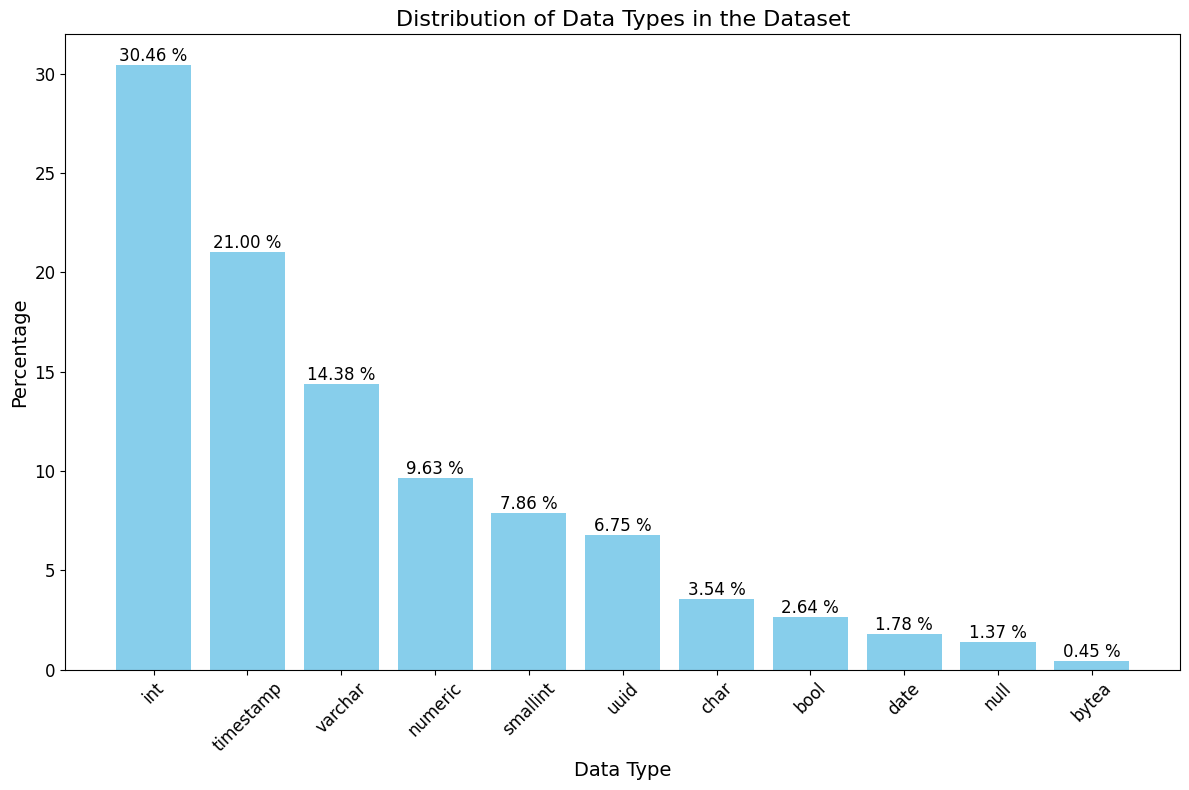

<Figure size 1400x1000 with 0 Axes>

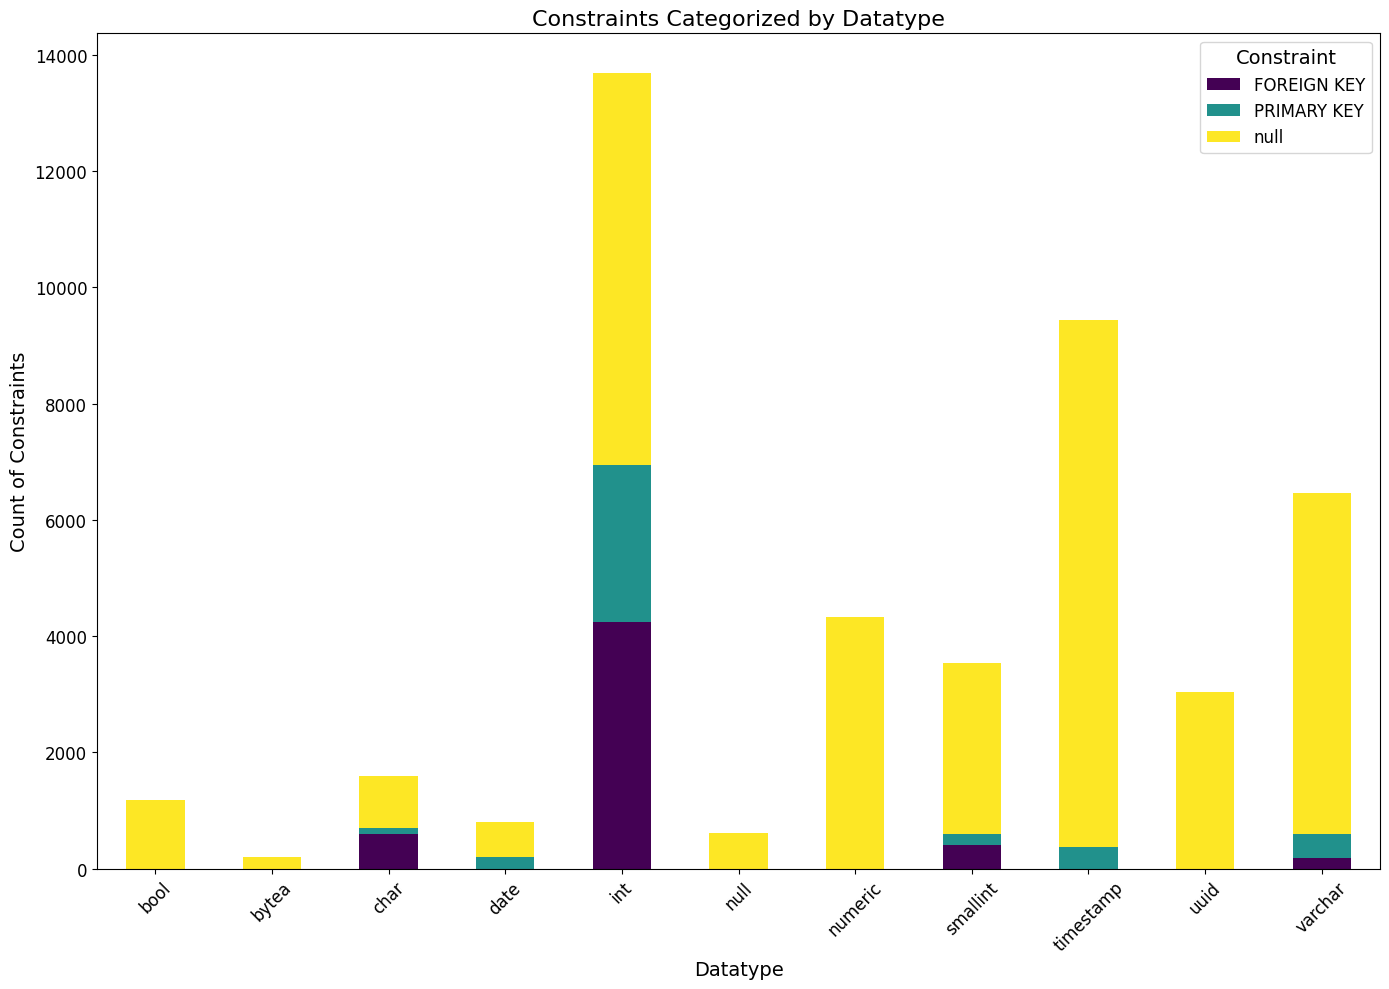

In [ ]:
# Import necessary libraries
import pandas as pd
import csv
import json
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_training_shuffledrows.csv"

# Check if the file exists
if not os.path.exists(csv_file):
    raise FileNotFoundError(f"The file {csv_file} does not exist. Please check the file path.")

# Initialize lists to store prompts and responses
prompts = []
responses = []

# Define the desired range (e.g., rows 10 to 30)
start_row = 0
end_row = 100000

try:
    with open(csv_file, newline='', encoding='utf-8') as csvfile:
        # Create a CSV reader
        reader = csv.reader(csvfile)

        # Skip the header
        header = next(reader)

        # Initialize a counter for total rows
        total_rows = 0

        # First, count the total number of rows
        for _ in reader:
            total_rows += 1
except OSError as e:
    print(f"Error reading the CSV file: {e}")
    raise

# Step 2: Open the CSV file
try:
    with open(csv_file, newline='', encoding='utf-8') as csvfile:
        # Create a CSV reader
        reader = csv.reader(csvfile)

        print("Total rows in input CSV File: ", total_rows)
        # Skip the header
        next(reader)
        # Iterate over each row in the CSV file
        for i, row in enumerate(reader):
            if i >= end_row:
                break
            if i >= start_row:
                # Append the prompt (first column) to the prompts list
                prompts.append(row[0])
                # Append the response (second column) to the responses list
                responses.append(row[1])
except OSError as e:
    print(f"Error reading the CSV file: {e}")
    raise

# Combine prompts and responses into a single list for easier sampling
combined_data = list(zip(prompts, responses))

# Sample 100% of the data
sampled_data = random.sample(combined_data, int(len(combined_data) * 1))

# Split the sampled data back into prompts and responses
sampled_prompts, sampled_responses = zip(*sampled_data)

# Convert sampled prompts and responses back to lists
sampled_prompts = list(sampled_prompts)
sampled_responses = list(sampled_responses)

# Use the sampled data for further processing
prompts = sampled_prompts
responses = sampled_responses
print("Total Sampled Data: ", len(prompts))

# Step 3: HANDLE PROMPT ###
flattened_prompts = [item for sublist in prompts for item in sublist.split(',')]

# Create a dataframe from the PROMPT list
PROMPT_DF = pd.DataFrame(flattened_prompts, columns=['Prompt_Element'])
PROMPT_DF['Prompt_Element'].replace('', 'No_Data', inplace=True)

# Step 4: HANDLE RESPONSE ###
# Initialize lists to store keys, datatypes, and constraints
keys = []
datatypes = []
constraints = []

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY',
    'FOREIGN KEY': 'FOREIGN KEY'
}

# Iterate over each response
for response in responses:
    # Replace single quotes with double quotes
    response_replaced = response.replace("'", '"')
    # Convert the JSON string to a Python dictionary
    response_dict = json.loads(response_replaced)
    # Extract keys, datatypes, and constraints
    for key, value in response_dict.items():
        keys.append(key)
        datatypes.append(value.get('type', 'null'))
        constraints.append(", ".join(value.get('constraints', ['null'])))

# Create a DataFrame from the lists
RESPONSE_DF = pd.DataFrame({
    'Key': keys,
    'Datatype': datatypes,
    'Constraints': constraints
})

# Ensure that 'null' is placed correctly where there are missing values
RESPONSE_DF['Datatype'].replace('', 'null', inplace=True)
RESPONSE_DF['Constraints'].replace('', 'null', inplace=True)

# Apply the mappings to the RESPONSE_DF DataFrame
RESPONSE_DF['Datatype'] = RESPONSE_DF['Datatype'].map(data_type_mapping).fillna('null')
RESPONSE_DF['Constraints'] = RESPONSE_DF['Constraints'].map(constraint_mapping).fillna('null')

# Step 5: MERGE PROMPT_DF AND RESPONSE_DF to make a MASTER DF ###
# Concatenate PROMPT_DF and RESPONSE_DF along columns
MASTER_DF_50 = pd.concat([PROMPT_DF, RESPONSE_DF], axis=1)

# Print unique values in the 'Datatype' column
unique_datatypes = RESPONSE_DF['Datatype'].unique()
print("Unique values in the 'Datatype' column:")
print(unique_datatypes)

# Print unique values in the 'Constraints' column
unique_constraints = RESPONSE_DF['Constraints'].unique()
print("\nUnique values in the 'Constraints' column:")
print(unique_constraints)

# Get the number of occurrences of each unique value in the 'Datatype' column
datatype_counts = MASTER_DF_50['Datatype'].value_counts()

# Get the number of occurrences of each unique value in the 'Constraints' column
constraint_counts = MASTER_DF_50['Constraints'].value_counts()

print("Number of occurrences of each datatype:")
print(datatype_counts)

print("\nNumber of occurrences of each constraint:")
print(constraint_counts)

# Get the data types of each column
#data_types = data.dtypes

# Classify columns by data type
#data_type_counts = data_types.value_counts()

# Convert the counts to a DataFrame for easier manipulation
data_type_counts_df50 = pd.DataFrame(datatype_counts, columns=['count'])

# Calculate the percentage distribution
data_type_counts_df50['percentage'] = (data_type_counts_df50['count'] / len(MASTER_DF_50)) * 100

# Plot the distribution of data types
plt.figure(figsize=(12, 8))
bars = plt.bar(data_type_counts_df50.index.astype(str), data_type_counts_df50['percentage'], color='skyblue')

# Add title and labels with improved font sizes
plt.title('Distribution of Data Types in the Dataset', fontsize=16)
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Step 6: Additional Plot for Constraints Categorized by Datatype ###
# Create a contingency table for constraints by datatype
constraint_by_datatype = pd.crosstab(MASTER_DF_50['Datatype'], MASTER_DF_50['Constraints'])

# Plot the constraints categorized by datatype
plt.figure(figsize=(14, 10))
constraint_by_datatype.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 10))

# Add title and labels with improved font sizes
plt.title('Constraints Categorized by Datatype', fontsize=16)
plt.xlabel('Datatype', fontsize=14)
plt.ylabel('Count of Constraints', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add legend with improved font size
plt.legend(title='Constraint', fontsize=12, title_fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()
